In this project I will analyze the baseball statistics from the [Lahman data](http://www.seanlahman.com/baseball-archive/statistics/) to address the following questions:

**1. What is the relationship between different performance metrics? Do any have a strong negative or positive relationship?**

**2. What are the characteristics of pitchers with the highest salaries?**

The analysis is divided into the following parts:

1. Selection of proper datapoints for analysis
2. Addition of extra stat columns
3. Q1: Analysis of the relationship between different performance metrics
4. Generation of stat-salary dataset for Q2
5. Q2: Analysis of characteristics of pitchers with highest-salaries

In [49]:
#imports and plot settings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes = True)
import pygal
import scipy.stats
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [50]:
# read performance metrics data
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
fielding = pd.read_csv('Fielding.csv')

# 1. Selection of proper datapoints for analysis

After the initial look at the datasets (See below), I found the following characteristics that I would like to take into account before starting the analysis.

1. There are **a lot of missing data(NaNs)**: the missing data come from two parts (See 1.1 batting section for an example). First, some of the stats are [not collected since the beginning](https://en.wikipedia.org/wiki/Baseball_statistics)(eg. IBB, GIDP, WP, SB). Second, a fraction (around 10 to 20%) of players' data are missing between 1973 to 1999. I am not sure of the reason but they all seem to be players that have only few games played. 

2. All three datasets have stats that are **positively skewed** as shown by the medians with players with low game numbers and low stat values. This may be due to the fact that there are utility players that are not in the starting line up and are only used for a specific game scenario, pitchers with different roles (start, relieve, set-up and close), subs for injured players, etc.

3. **The SD (standard deviation) is large** for most of the stats which suggests that the dataset is widely spread and less reliable. 

These Lahman data contains baseball stats from 1871 to 2014. During this time, there had been many changes to the game rules and many of them would have affected the stats. Some of the examples may include the number of games per season, the number of teams in each league, the number of leagues, etc.. To reduce these external factors that might play a role in affecting the outcome of the stats values, I will **[only look at stats from 1998 to 2012](https://en.wikipedia.org/wiki/Major_League_Baseball_schedule)**. During this time, there has been 30 teams in two leagues (NL and AL) that played in a single advance schedule with each team playing 162 games

## 1.1 Batting

For players in the batting category, I will only look at players that had **more than 251 [PAs(Plate Appearances)](https://en.wikipedia.org/wiki/Plate_appearance)**: A higher PA is likely a reflection that a player is active during the season. It can be quite tricky to determine whether a player is active during the season as a player can stop playing in the game due to various reasons (injury, bad performance, sickness, suspension). PA is a statistic used to qualify batters for winning the [batting title](https://en.wikipedia.org/wiki/Batting_average#Major_League_Baseball). A batter is required to have more than 502 PA to enter the competition. There had been examples where this requirement is sometimes too strict, so I have arbitrarily picked 502/2 as the cut off line.   


In [51]:
# first look of batting
print batting.head()
print "-------------------------------------------------------------------------------------"
print batting.describe()

    playerID  yearID  stint teamID lgID   G     AB     R     H    2B   3B  \
0  abercda01    1871      1    TRO  NaN   1    4.0   0.0   0.0   0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118.0  30.0  32.0   6.0  0.0   
2  allisar01    1871      1    CL1  NaN  29  137.0  28.0  40.0   4.0  5.0   
3  allisdo01    1871      1    WS3  NaN  27  133.0  28.0  44.0  10.0  2.0   
4  ansonca01    1871      1    RC1  NaN  25  120.0  29.0  39.0  11.0  3.0   

    HR   RBI   SB   CS   BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0.0  0.0  0.0  0.0  0.0  NaN  NaN NaN NaN   NaN  
1  0.0  13.0  8.0  1.0  4.0  0.0  NaN  NaN NaN NaN   NaN  
2  0.0  19.0  3.0  1.0  2.0  5.0  NaN  NaN NaN NaN   NaN  
3  2.0  27.0  1.0  1.0  0.0  2.0  NaN  NaN NaN NaN   NaN  
4  0.0  16.0  6.0  2.0  2.0  1.0  NaN  NaN NaN NaN   NaN  
-------------------------------------------------------------------------------------
             yearID         stint             G            AB             R  \
count  99846.00000

There are 99846 data points in this dataset. For most stats, the standard deviation is large, more than the mean, suggesting that the dataset has a wide range and might be less reliable. The median is also very low, some of them has 0 value, indicating the the stats are very positively skewed. For some stats, there are some missing numbers that I will look into next.

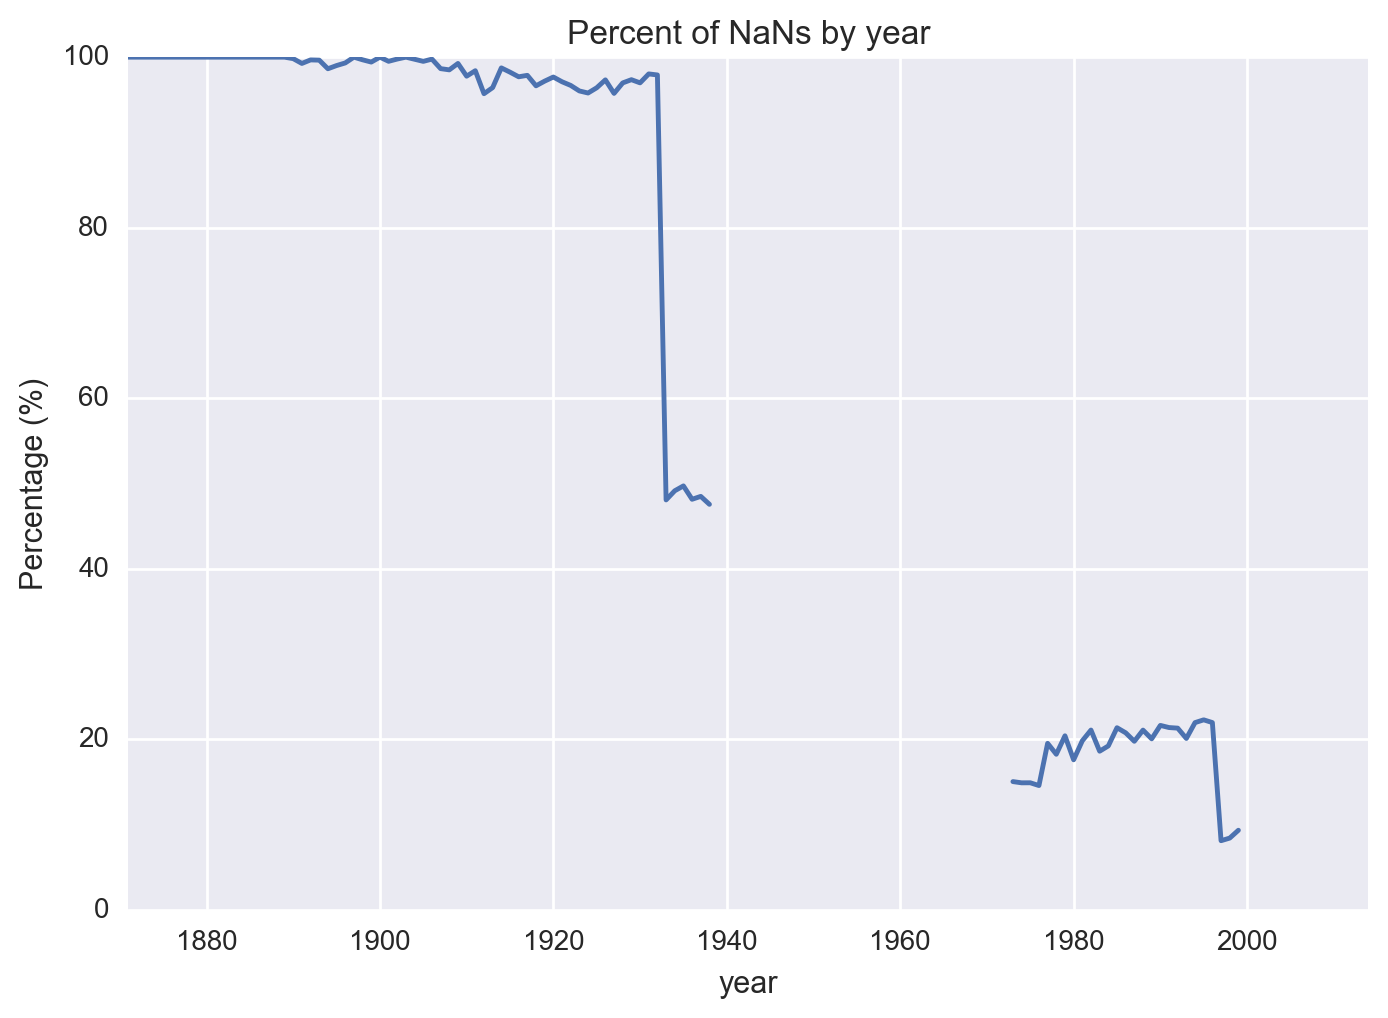

In [52]:
# write a function to look at the NaNs over time

def get_NaN_plot(dataset, column_name, ax = None):
    '''This function prints out a plot that shows the percentage of players with NaNs in a specific stat column.
      It takes in a dataset and a column_name in that dataset as a string representing the stat category and 
      outputs a line plot with percentage of NaNs grouped by year. As an optional parameter it also takes an ax
      and return an ax object for generating subplots.
    '''   
    #try count the number of datapoints with NaN grouped by year
    NaN_count = dataset[dataset[column_name].isnull() == True].groupby(['yearID']).count()
    #print NaN_count

    #compare the table to the total player ids each year
    playerid_count_per_year = dataset.groupby(['yearID']).count()
    #print playerid_count_per_year

    #get percentage of players with NaNs
    players_with_NaN_percentage = NaN_count['playerID']/playerid_count_per_year['playerID']*100
    #print players_with_NaN_percentage
    return players_with_NaN_percentage.plot(title = 'Percent of NaNs by year', ax = ax)

# use GIDP as an example to show the two categories of NaNs
ax = get_NaN_plot(batting, 'GIDP')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('year')

In [53]:
# write a function to select subdatasets from 1998 to 2012

def get_98_to_12(data):
    new_data = data[(data['yearID'] >= 1998) & (data['yearID'] <= 2012)]
    return new_data

# create new dataset
batting_98_to_12 = get_98_to_12(batting)

In [54]:
# Make a new column with PA = AB + BB + HBP + SH + SF + Times Reached on Defensive Interference
# will leave out times reached on defensive interference because the data is not available in this dataset
batting_98_to_12 = batting_98_to_12.assign(PA = (batting_98_to_12['AB'] + batting_98_to_12['BB'] + \
                         batting_98_to_12['HBP'] + batting_98_to_12['SH'] + batting_98_to_12['SF']).round(2))    

In [55]:
# Select rows with PA > 251 to a new dataset
batting_98_12_251PA = batting_98_to_12[batting_98_to_12['PA'] >= 251]

# check the dataset
print batting_98_12_251PA.describe()

            yearID        stint            G           AB            R  \
count  4500.000000  4500.000000  4500.000000  4500.000000  4500.000000   
mean   2005.018667     1.018222   124.454667   433.749778    62.566889   
std       4.302117     0.137052    26.593504   124.429099    25.621629   
min    1998.000000     1.000000    57.000000   208.000000    13.000000   
25%    2001.000000     1.000000   104.000000   324.000000    42.000000   
50%    2005.000000     1.000000   129.000000   439.000000    59.000000   
75%    2009.000000     1.000000   148.000000   543.000000    82.000000   
max    2012.000000     3.000000   163.000000   716.000000   152.000000   

                 H           2B           3B           HR          RBI  \
count  4500.000000  4500.000000  4500.000000  4500.000000  4500.000000   
mean    119.095333    23.950000     2.498444    14.622667    59.884000   
std      40.615245     9.838931     2.527774    10.538441    27.837873   
min      38.000000     2.000000     0

After selection there are 4500 data points in the dataset. The standard deviation is much smaller and the median for some stats is also closer to the mean now. 

## 1.2 Pitching

Whereas batters that make more contribution to the team tend to have higher number of games played, it's harder to make such call for pitchers. That is because the [role of pitchers](https://en.wikipedia.org/wiki/Pitcher) had been divided into several types (starting pitcher, relief pitcher, middle reliever, lefty specialist, setup man, and closer) so that each pitcher's role is very specialized and they don't generally play throughout the game. One way to determine if a pitcher is active throughout the season is the number of ['IPouts' (outs pitched or innings pitched x 3)](https://en.wikipedia.org/wiki/Innings_pitched). It measures the number of batters and base runners that are put out while the pitcher is at the pitching mount. It is unlikely that a pitcher would have 0 IPouts if he is actively playing during the season so I will remove pitchers with IPouts = 0 in the dataset after year selection.

In [56]:
# first look of pitching
print pitching.head()
print "-------------------------------------------------------------------------------------"
print pitching.describe()

    playerID  yearID  stint teamID lgID   W   L   G  GS  CG  SHO  SV  IPouts  \
0  bechtge01    1871      1    PH1  NaN   1   2   3   3   2    0   0    78.0   
1  brainas01    1871      1    WS3  NaN  12  15  30  30  30    0   0   792.0   
2  fergubo01    1871      1    NY2  NaN   0   0   1   0   0    0   0     3.0   
3  fishech01    1871      1    RC1  NaN   4  16  24  24  22    1   0   639.0   
4  fleetfr01    1871      1    NY2  NaN   0   1   1   1   1    0   0    27.0   

     H   ER  HR  BB  SO  BAOpp    ERA  IBB  WP  HBP  BK  BFP  GF    R  SH  SF  \
0   43   23   0  11   1    NaN   7.96  NaN NaN  NaN   0  NaN NaN   42 NaN NaN   
1  361  132   4  37  13    NaN   4.50  NaN NaN  NaN   0  NaN NaN  292 NaN NaN   
2    8    3   0   0   0    NaN  27.00  NaN NaN  NaN   0  NaN NaN    9 NaN NaN   
3  295  103   3  31  15    NaN   4.35  NaN NaN  NaN   0  NaN NaN  257 NaN NaN   
4   20   10   0   3   0    NaN  10.00  NaN NaN  NaN   0  NaN NaN   21 NaN NaN   

   GIDP  
0   NaN  
1   NaN  
2 

There are 43330 data points in this dataset. The number is less because there are less pitchers in a team than batters. The trend in standard deviation and median is very similar to the batting dataset, with large standard deviation and small medians, indicating positively skewed stats. 

In [57]:
# do year selection
pitching_98_to_12 = get_98_to_12(pitching)

# After year selection it appears that GIDP records are not kept during this time period so I will drop the column
pitching_98_to_12 = pitching_98_to_12.drop('GIDP', axis = 1)

# remove rows with 0 IPouts and create a new dataset
pitching_98_to_12_no0IPouts = pitching_98_to_12[pitching_98_to_12['IPouts'] != 0.0]
print pitching_98_to_12_no0IPouts.describe()

             yearID         stint             W             L             G  \
count  10214.000000  10214.000000  10214.000000  10214.000000  10214.000000   
mean    2005.163109      1.087331      3.566869      3.566673     26.794791   
std        4.305847      0.296542      4.387790      3.799129     21.122773   
min     1998.000000      1.000000      0.000000      0.000000      1.000000   
25%     2001.000000      1.000000      0.000000      1.000000      9.000000   
50%     2005.000000      1.000000      2.000000      2.000000     23.000000   
75%     2009.000000      1.000000      5.000000      5.000000     36.000000   
max     2012.000000      4.000000     24.000000     21.000000     94.000000   

                 GS            CG           SHO            SV        IPouts  \
count  10214.000000  10214.000000  10214.000000  10214.000000  10214.000000   
mean       7.135207      0.268553      0.100646      1.788623    190.887801   
std       11.073393      0.887612      0.400056    

After selection there are 10214 data points left. Most of the stats are complete except BAOpp(Opponents Batting Average), SH(Sacrifice Hit by opposing batters) and SF(Sacrifice Flies by opposing batters) so I will take a closer look.

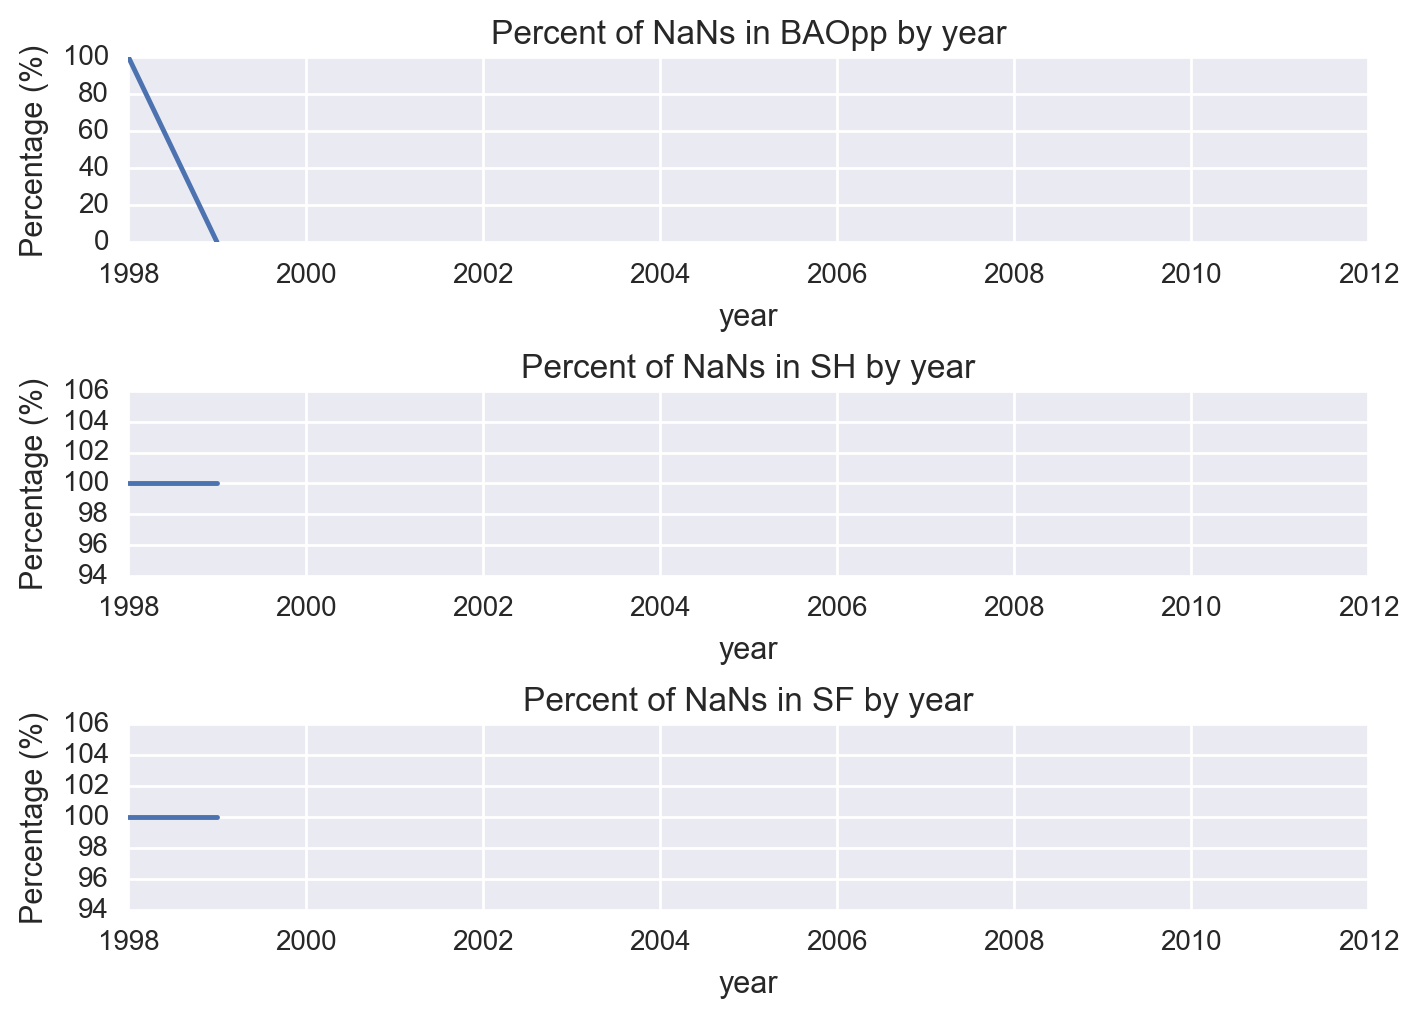

In [58]:
# take a look at NaNs of BAOpp, SH, SF
f, (ax1, ax2, ax3) = plt.subplots(3)

get_NaN_plot(pitching_98_to_12_no0IPouts, 'BAOpp', ax = ax1)
get_NaN_plot(pitching_98_to_12_no0IPouts, 'SH', ax = ax2)
get_NaN_plot(pitching_98_to_12_no0IPouts, 'SF', ax = ax3)
f.subplots_adjust(hspace=0.8)
ax1.set_ylabel('Percentage (%)')
ax1.set_xlabel('year')
ax1.set_title('Percent of NaNs in BAOpp by year')
ax2.set_ylabel('Percentage (%)')
ax2.set_xlabel('year')
ax2.set_title('Percent of NaNs in SH by year')
ax3.set_ylabel('Percentage (%)')
ax3.set_xlabel('year')
ax3.set_title('Percent of NaNs in SF by year')

It looks like for 1998 and 1999, there are no records for BAOpp (1998 only), SF and SH. The amount of missing data is large thus make it hard to imputate with average or median number. Here I have the option of dropping the years 1998 and 1999 or dropping these three stats columns. Because these stats are not the most common/important pitcher stats, I have decided to **keep the year so that it's consistent between batting and pitching analysis and drop these three stats.**

In [59]:
#drop columns 'BAOpp', 'SH', 'SF'
pitching_98_to_12_no0IPouts = pitching_98_to_12_no0IPouts.drop(['BAOpp', 'SH', 'SF'], axis = 1)

## 1.3 Fielding

My original plan was to merge fielding stats into batting and pitching because batters perform fielding during defensive play and pitchers are considered part of fielding. However, upon examining the data, there were too many missing values in fielding that I have decided to leave the fielding stats out.

In [60]:
# first look of fielding
print fielding.head()
print "-------------------------------------------------------------------------------------"
print fielding.describe()

    playerID  yearID  stint teamID lgID POS   G  GS  InnOuts    PO     A  \
0  abercda01    1871      1    TRO  NaN  SS   1 NaN      NaN   1.0   3.0   
1   addybo01    1871      1    RC1  NaN  2B  22 NaN      NaN  67.0  72.0   
2   addybo01    1871      1    RC1  NaN  SS   3 NaN      NaN   8.0  14.0   
3  allisar01    1871      1    CL1  NaN  2B   2 NaN      NaN   1.0   4.0   
4  allisar01    1871      1    CL1  NaN  OF  29 NaN      NaN  51.0   3.0   

      E   DP  PB  WP  SB  CS  ZR  
0   2.0  0.0 NaN NaN NaN NaN NaN  
1  42.0  5.0 NaN NaN NaN NaN NaN  
2   7.0  0.0 NaN NaN NaN NaN NaN  
3   0.0  0.0 NaN NaN NaN NaN NaN  
4   7.0  1.0 NaN NaN NaN NaN NaN  
-------------------------------------------------------------------------------------
              yearID          stint              G            GS  \
count  167938.000000  167938.000000  167938.000000  75849.000000   
mean     1965.769981       1.077499      33.683514     26.930823   
std        38.369956       0.283110      41

There are 167938 data points in the dataset but with very large amount of missing data in some of the stats. The trend also looks positively skewed like batting and pitching

In [61]:
# before merging I would like to check the NaN situation in the year_selection subset first
fielding_98_12 = get_98_to_12(fielding)

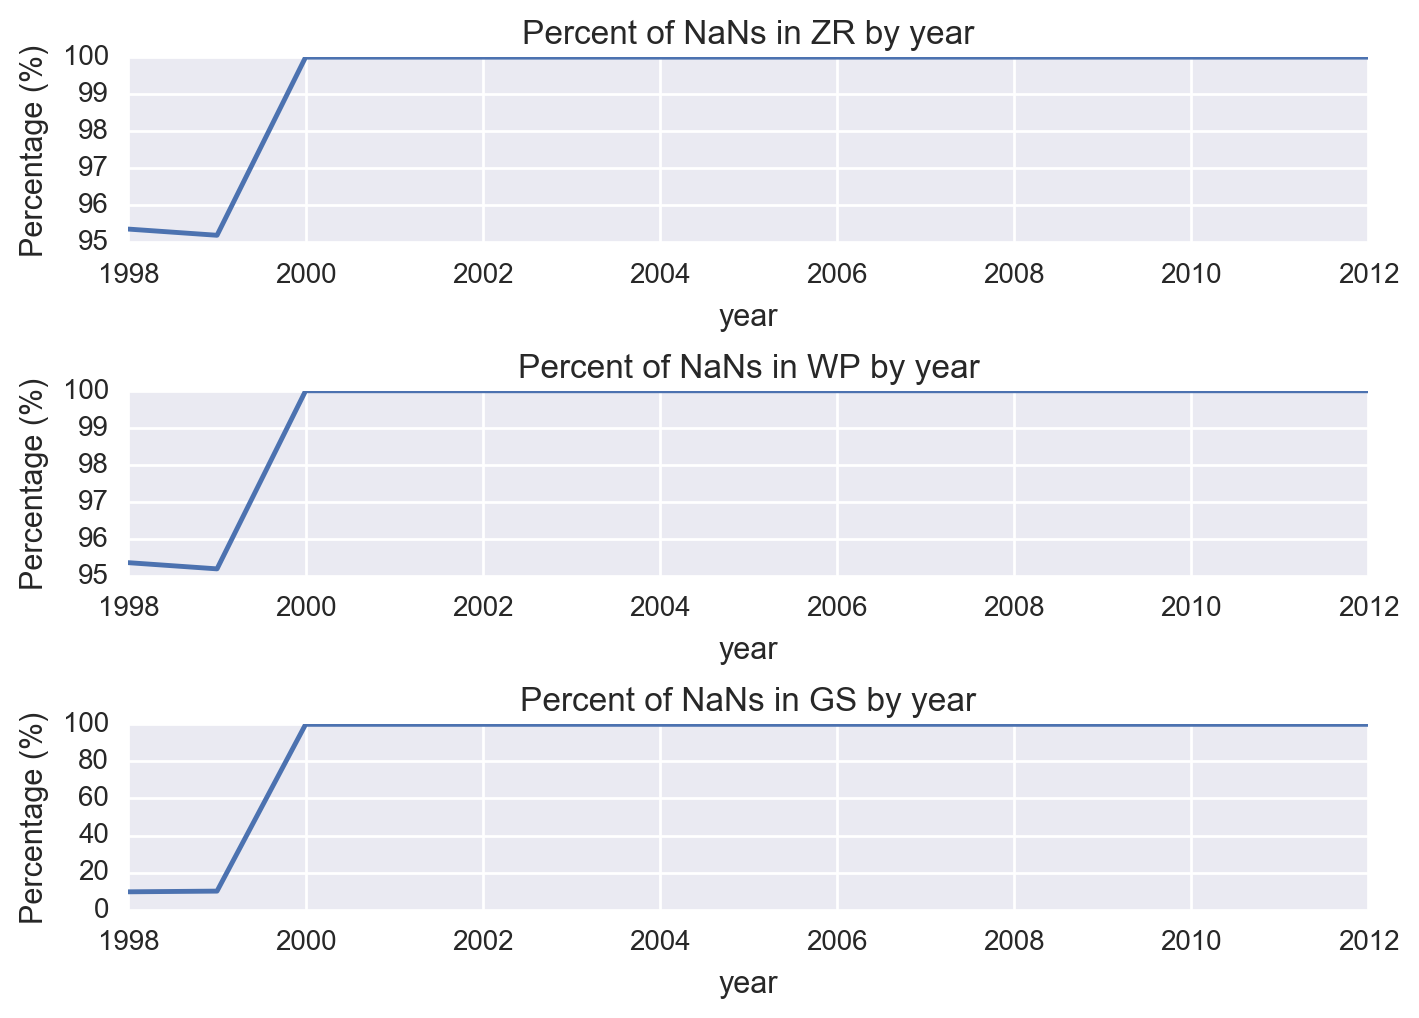

In [62]:
# ckeck out missing values in ZR and WP

f1, (ax1, ax2, ax3) = plt.subplots(3)

get_NaN_plot(fielding_98_12, 'ZR', ax = ax1)
get_NaN_plot(fielding_98_12, 'WP', ax = ax2)
get_NaN_plot(fielding_98_12, 'GS', ax = ax3)
f1.subplots_adjust(hspace = 0.8)

ax1.set_ylabel('Percentage (%)')
ax1.set_xlabel('year')
ax1.set_title('Percent of NaNs in ZR by year')
ax2.set_ylabel('Percentage (%)')
ax2.set_xlabel('year')
ax2.set_title('Percent of NaNs in WP by year')
ax3.set_ylabel('Percentage (%)')
ax3.set_xlabel('year')
ax3.set_title('Percent of NaNs in GS by year')

There is no data on ZR(Zone Rating), WP(Wild Pitches by catchers) and GS(Games Started) after year 2000

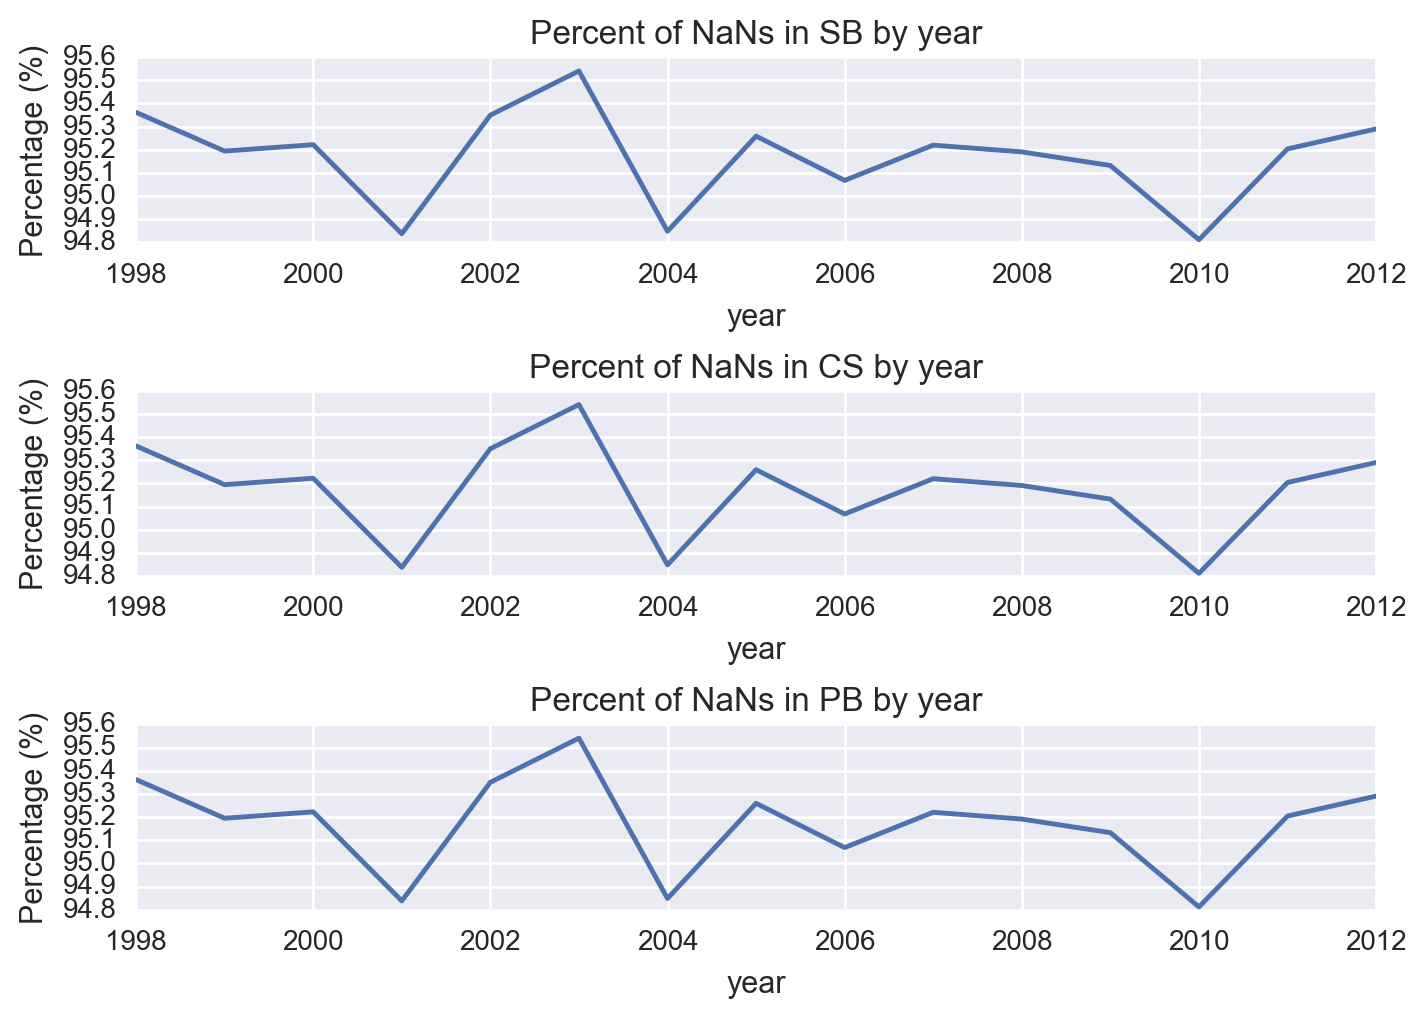

In [63]:
# check NaNs in SB, CS, PB
f2, (ax4, ax5, ax6) = plt.subplots(3)

get_NaN_plot(fielding_98_12, 'SB', ax = ax4)
get_NaN_plot(fielding_98_12, 'CS', ax = ax5)
get_NaN_plot(fielding_98_12, 'PB', ax = ax6)

f2.subplots_adjust(hspace = 0.8)

ax4.set_ylabel('Percentage (%)')
ax4.set_xlabel('year')
ax4.set_title('Percent of NaNs in SB by year')
ax5.set_ylabel('Percentage (%)')
ax5.set_xlabel('year')
ax5.set_title('Percent of NaNs in CS by year')
ax6.set_ylabel('Percentage (%)')
ax6.set_xlabel('year')
ax6.set_title('Percent of NaNs in PB by year')

There are more than 94% of data missing in SB(Opponent Stolen Bases by catchers), CS(Opponent Caught Stealing by catchers) and PB(Passed Balls by catchers) every year.

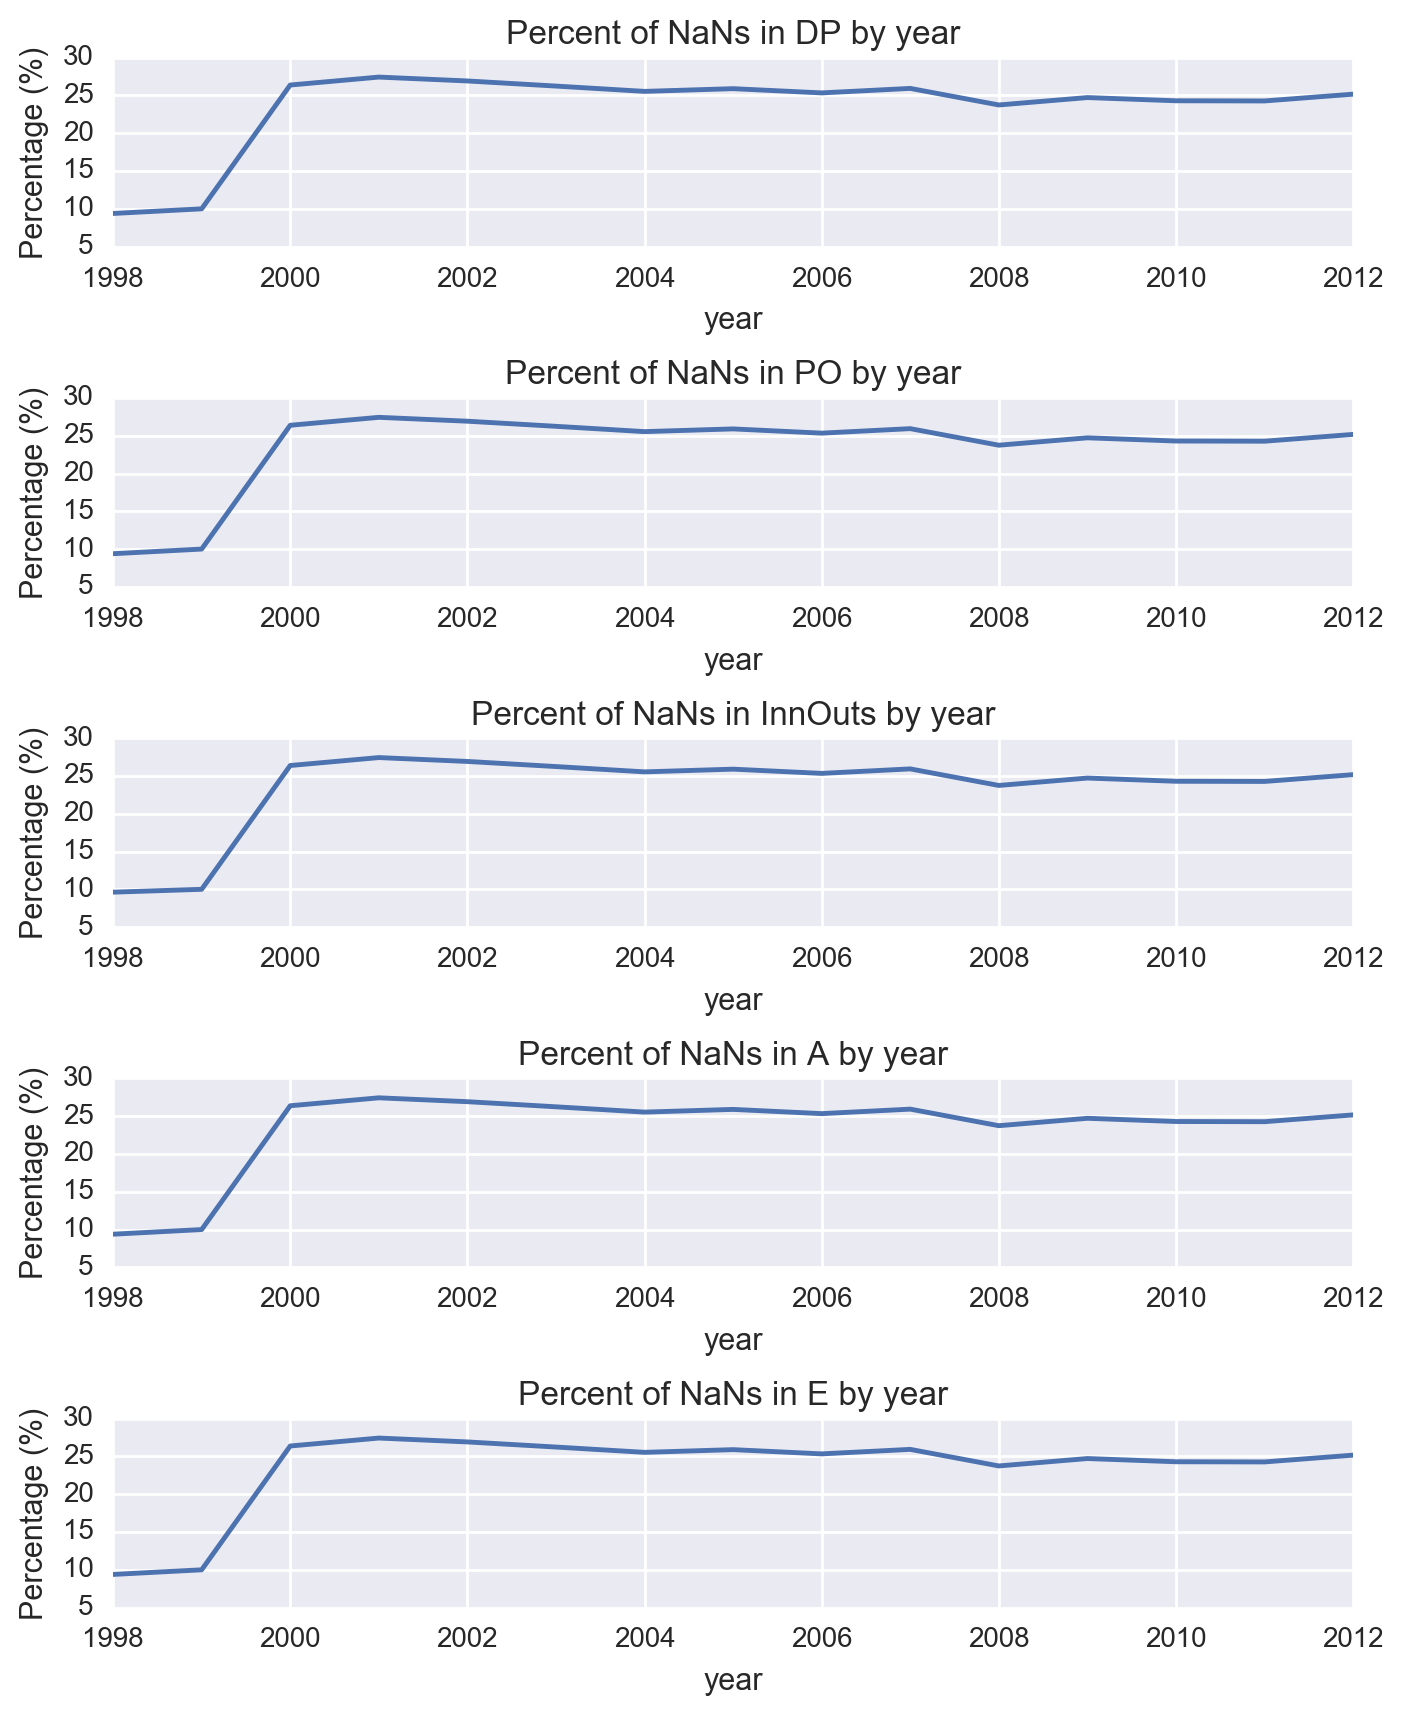

In [64]:
# check NaNs in DP, PO, InnOuts, A, E
f3, (ax7, ax8, ax9, ax10, ax11) = plt.subplots(5, figsize = (8, 10))

get_NaN_plot(fielding_98_12, 'DP', ax = ax7)
get_NaN_plot(fielding_98_12, 'PO', ax = ax8)
get_NaN_plot(fielding_98_12, 'InnOuts', ax = ax9)
get_NaN_plot(fielding_98_12, 'A', ax = ax10)
get_NaN_plot(fielding_98_12, 'E', ax = ax11)

f3.subplots_adjust(hspace = 0.8)

ax7.set_ylabel('Percentage (%)')
ax7.set_xlabel('year')
ax7.set_title('Percent of NaNs in DP by year')
ax8.set_ylabel('Percentage (%)')
ax8.set_xlabel('year')
ax8.set_title('Percent of NaNs in PO by year')
ax9.set_ylabel('Percentage (%)')
ax9.set_xlabel('year')
ax9.set_title('Percent of NaNs in InnOuts by year')
ax10.set_ylabel('Percentage (%)')
ax10.set_xlabel('year')
ax10.set_title('Percent of NaNs in A by year')
ax11.set_ylabel('Percentage (%)')
ax11.set_xlabel('year')
ax11.set_title('Percent of NaNs in E by year')

There is a ~10% to 30% data missing each year in DP(Double Plays), PO(PutOuts), InnOuts(Time played in the field expressed as outs), A(Assists) and E(Errors).
Because of the large amount of missing data, I am not confident about this dataset so **I will not include it in the final analysis.**

# 2. Addition of extra stat columns 
In both the batting and pitching dataset there were some important stats that are used in MLB but not included in the datasets. I will add those in before starting the analysis. 

## 2.1 Batting
[Batting Average(BA)](http://m.mlb.com/glossary/standard-stats/batting-average): this is one of the oldest and universal indicator to measure a batter's ability at the plate. It is calculated by dividing a player's hits by at bats.

[On Base Percentage(OBP)](http://m.mlb.com/glossary/standard-stats/on-base-percentage): it measures how frequent a hitter reaches base per plate appearance. 

[Slugging Percentage(SLG)](http://m.mlb.com/glossary/standard-stats/slugging-percentage): it represents the total number of bases, excluding walks and hit by pitchers, a player records per at bat. It aims at fixing a major flaw in batting average by giving different types of hits (1B, 2B, 3B and HR) different weights. 

[On Base Plus Slugging(OPS)](http://m.mlb.com/glossary/standard-stats/on-base-plus-slugging): this is a comprehensive and measurement of how well a hitter can reach base and hit for average and for power. 

All equations for these stats can be found [here](http://profastpitch.com.ismmedia.com/ISM3/std-content/repos/Top/2014%20Website/Statistics/Commonly%20Used%20Statistics.pdf)

In [65]:
# 1B = H - 2B - 3B - HR
batting_98_12_251PA = batting_98_12_251PA.assign(_1B = (batting_98_12_251PA['H'] - batting_98_12_251PA['2B'] -
                                                       batting_98_12_251PA['3B'] - 
                                                        batting_98_12_251PA['HR']).round(2))

# BA = H / AB
batting_98_12_251PA = batting_98_12_251PA.assign(BA = (batting_98_12_251PA['H'] / batting_98_12_251PA['AB']).round(2))

# OBP = (H + BB + HBP) / (AB + BB + HBP + SF)
batting_98_12_251PA = batting_98_12_251PA.assign(OBP = ((batting_98_12_251PA['H'] + batting_98_12_251PA['BB'] +
                                                       batting_98_12_251PA['HBP']) / 
                                                       (batting_98_12_251PA['AB'] + batting_98_12_251PA['BB'] +
                                                       batting_98_12_251PA['HBP'] + 
                                                        batting_98_12_251PA['SF'])).round(2))

# SLG = (H + 2B + (2 * 3B) + (3 * HR)) / AB
batting_98_12_251PA = batting_98_12_251PA.assign(SLG = ((batting_98_12_251PA['H'] + batting_98_12_251PA['2B'] +
                                                       (2 * batting_98_12_251PA['3B']) +
                                                       (3 * batting_98_12_251PA['HR'])) / 
                                                        batting_98_12_251PA['AB']).round(2))

# OPS = OBP + SLG
batting_98_12_251PA = batting_98_12_251PA.assign(OPS = (batting_98_12_251PA['OBP'] + 
                                                        batting_98_12_251PA['SLG']).round(2))
# check that the columns are created
print batting_98_12_251PA.head()

        playerID  yearID  stint teamID lgID    G     AB     R      H    2B  \
76627  abbotje01    1998      1    CHA   AL   89  244.0  33.0   68.0  14.0   
76632  abreubo01    1998      1    PHI   NL  151  497.0  68.0  155.0  29.0   
76639  alexama02    1998      1    CHN   NL  108  264.0  34.0   60.0  10.0   
76641  alfoned01    1998      1    NYN   NL  144  557.0  94.0  155.0  28.0   
76642  alicelu01    1998      1    TEX   AL  101  259.0  51.0   71.0  15.0   

        3B    HR   RBI    SB    CS    BB     SO   IBB  HBP   SH   SF  GIDP  \
76627  1.0  12.0  41.0   3.0   3.0   9.0   28.0   1.0  0.0  2.0  5.0   2.0   
76632  6.0  17.0  74.0  19.0  10.0  84.0  133.0  14.0  0.0  4.0  4.0   6.0   
76639  1.0   5.0  25.0   4.0   1.0  18.0   66.0   1.0  1.0  5.0  1.0   6.0   
76641  2.0  17.0  78.0   8.0   3.0  65.0   77.0   1.0  3.0  2.0  3.0  11.0   
76642  3.0   6.0  33.0   4.0   3.0  37.0   40.0   0.0  5.0  4.0  3.0   1.0   

          PA    _1B    BA   OBP   SLG   OPS  
76627  260.0   4

## 2.1 Pitching
[Walks and Hits Per Inning Pitched(WHIP)](http://m.mlb.com/glossary/standard-stats/walks-and-hits-per-inning-pitched): This is one of the most commonly used stats and measures how well a pitcher has kept the runner off basepaths.


In [66]:
# WHIP = (H + BB) / (IPOuts / 3) 
pitching_98_to_12_no0IPouts = pitching_98_to_12_no0IPouts.assign(WHIP = ((pitching_98_to_12_no0IPouts['H'] +
                                                                    pitching_98_to_12_no0IPouts['BB']) / 
                                                                    (pitching_98_to_12_no0IPouts['IPouts'] / 
                                                                     3)).round(2))

# check that the column is created
print pitching_98_to_12_no0IPouts.head()

        playerID  yearID  stint teamID lgID  W  L   G  GS  CG  SHO  SV  \
31635  abbotji01    1998      1    CHA   AL  5  0   5   5   0    0   0   
31636  abbotpa01    1998      1    SEA   AL  3  1   4   4   0    0   0   
31637  aceveju01    1998      1    SLN   NL  8  3  50   9   0    0  15   
31638  adamsjo02    1998      1    ARI   NL  0  3   5   5   0    0   0   
31639  adamste01    1998      1    CHN   NL  7  7  63   0   0    0   1   

       IPouts   H  ER  HR  BB  SO   ERA  IBB   WP  HBP  BK    BFP    GF   R  \
31635    95.0  35  16   2  12  14  4.55  0.0  0.0  1.0   0  134.0   0.0  16   
31636    74.0  24  11   2  10  22  4.01  0.0  3.0  0.0   0  105.0   0.0  11   
31637   295.0  83  28   7  29  56  2.56  2.0  3.0  4.0   0  394.0  29.0  30   
31638    69.0  25  21   5  11  14  8.22  0.0  0.0  3.0   0  104.0   0.0  21   
31639   218.0  72  35   7  41  73  4.33  3.0  4.0  1.0   3  330.0  15.0  39   

       WHIP  
31635  1.48  
31636  1.38  
31637  1.14  
31638  1.57  
31639  1.5

# 3. Q1: Analysis of the relationship between different performance metrics

To analyze the relationship between different performance metrics, I will use [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence). Correlation is a statistical method that describes quantitatively the magnitude and direction of how two independent variables are varying together linearly. 

The most common way to measure correlation is to calculate the Pearson's correlation coefficient. For two group of samples $x_i$ and $y_i$ for i = 1, 2, 3....n, in which the samples means and standard errors are $\bar x$, $\bar y$ and $S_x$ and $S_y$, respectively, the sample correlation coefficient $r_{xy}$ is calculated as follows:
\begin{equation*}
r_{xy} = \frac{\sum_{i=1}^n(x_i-\bar x)(y_i-\bar y)}{(n-1)S_xS_y}
\end{equation*}
The value of r ranges from -1 (perfect inverse correlation) to 1 (perfect positive correlation) with 0 indicating no correlation at all. 

After computing Pearson's r we can perform a [hypothesis testing](https://onlinecourses.science.psu.edu/statprogram/node/138) by obtaining the *P*-value for each Pearson's r. We first set up our Null Hypothesis as $H_0: r = 0$ and Alternate Hypothesis as $H_A: r >0$ or $r <0$. Because we don't know if the two variables are going to be positively or negatively related, we will choose a two-tailed test. We then ask the question of "At a specified $\alpha$ level, if the hypothesis is true, what is the probability for us to observe a more extreme r score in the direction of the alternative hypothesis than we do?" If the *P*-value <= $\alpha$, we reject the Null Hypothesis. Otherwise, we retain the Null Hypothesis.  

It is worth noting that Pearson's r is only interpretable under the assumption that the samples come from normally distributed populations. This is not true in many of the stats we have. However, this assumption becomes less important if the n is large, which it is in this case so I decided to use Pearson's r as a measurement.  

Another important assumption for Preason's r to be considered is that the two variables should be independent. For example, doubles(2B) and triples(3B) are two events that happen independently. On the other hand, Batting Average(BA), which was calculated as H/AB is not independent of H or AB. Therefore, I will first select a list of independent stats for Pearson's r analysis.

In [67]:
# Make a list of independent stats
batting_independent_stats = ['AB', 'R', '_1B', '2B', '3B', 'HR', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 
                             'SF', 'GIDP']
pitching_independent_stats = ['W', 'L', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'ER', 'BB', 'SO', 'IBB', 
                             'WP', 'HBP', 'BK', 'GF']

# Compute pearson's R table to compare correlation between two independent stats

batting_98_12_251PA_pearsonr = batting_98_12_251PA[batting_independent_stats].corr()
pitching_98_to_12_no0IPouts_pearsonr = pitching_98_to_12_no0IPouts[pitching_independent_stats].corr()

# compute the p value matrix for batting
def get_pvalue_batting(column):
    '''This function takes a single stat column and return the p values of the pearsonr with 
    each of the stats in the batting stat dataset using scipy.stats.pearsonr. The output is returned as a pandas 
    Series.'''
    pvalues = []
    for stat in batting_independent_stats:
        _, pval = scipy.stats.pearsonr(column, batting_98_12_251PA[stat])
        pvalues.append(pval)
    return pd.Series(pvalues)

batting_98_12_251PA_pearsonr_pvalue = batting_98_12_251PA[batting_independent_stats].apply(get_pvalue_batting)
batting_98_12_251PA_pearsonr_pvalue.index = batting_independent_stats

# for pitching

def get_pvalue_pitching(column):
    '''This function takes a single stat column and return the p values of the pearsonr with 
    each of the stats in the pitching stat dataset using scipy.stats.pearsonr. The output is returned as a pandas 
    Series.'''
    pvalues = []
    for stat in pitching_independent_stats:
        _, pval = scipy.stats.pearsonr(column, pitching_98_to_12_no0IPouts[stat])
        pvalues.append(pval)
    return pd.Series(pvalues)

pitching_98_to_12_no0IPouts_pearsonr_pvalue = pitching_98_to_12_no0IPouts[pitching_independent_stats].apply(
                                                get_pvalue_pitching)
pitching_98_to_12_no0IPouts_pearsonr_pvalue.index = pitching_independent_stats

In [68]:
# find highest pearson r value for each column with it's corresponding Y variable and the p_value

def get_second_largest(column):
    '''This functions takes a pandas dataframe column and returns the second largest value of the column with 
    the corresponding row label'''
    sorted_column = column.sort_values(ascending = False)
    return pd.Series([sorted_column[1], sorted_column.index[1]])

# batting
batting_highest_pearsonr = batting_98_12_251PA_pearsonr.apply(get_second_largest).transpose().rename(columns = 
                            {0:'pearsonr', 1:'variable_Y'})
batting_highest_pearsonr.sort_values('pearsonr', ascending = False, inplace = True)

# pitching
pitching_highest_pearsonr = pitching_98_to_12_no0IPouts_pearsonr.apply(get_second_largest).transpose().rename(columns = 
                            {0:'pearsonr', 1:'variable_Y'})
pitching_highest_pearsonr.sort_values('pearsonr', ascending = False, inplace = True)


# match p value to the highest pearsons r table

def match_pvalue(pearsonr_data, pvalue_data):
    '''This function takes two dataframes that contain pearsonr value in one and pvalue in the other and return
    pandas Series containing the pvalues matched according to the indexes in the pearsonr table. Note: the row_index
    equals the row_index in pearsonr data; the column index is defined in a column named 'variable_Y' in the 
    pearsonr data.'''
    
    row_index = pearsonr_data.index.tolist()
    column_index = pearsonr_data['variable_Y'].tolist()
    pval_list = []

    for row, column in zip(row_index, column_index):
        pvalue = pvalue_data.loc[row, column]
        pval_list.append(pvalue)
        
    return pd.Series(pval_list)

batting_highest_pearsonr = batting_highest_pearsonr.assign(p_value = match_pvalue(batting_highest_pearsonr,
                                                                        batting_98_12_251PA_pearsonr_pvalue).values)
pitching_highest_pearsonr = pitching_highest_pearsonr.assign(p_value = match_pvalue(pitching_highest_pearsonr,
                                                                pitching_98_to_12_no0IPouts_pearsonr_pvalue).values)

# check if the p_value is less than 0.05 to reject the null hypothesis

batting_highest_pearsonr = batting_highest_pearsonr.assign(Null_Hypothesis_Rejected = 
                                                           (batting_highest_pearsonr['p_value'] <= 0.05))
pitching_highest_pearsonr = pitching_highest_pearsonr.assign(Null_Hypothesis_Rejected = 
                                                            (pitching_highest_pearsonr['p_value'] <= 0.05))

print "BATTING"
batting_highest_pearsonr = batting_highest_pearsonr[['variable_Y', 'pearsonr', 'p_value', 'Null_Hypothesis_Rejected']]
print batting_highest_pearsonr
print "------------------------------------------------------------------------------------"
print "PITCHING"
pitching_highest_pearsonr = pitching_highest_pearsonr[['variable_Y', 'pearsonr', 'p_value', 
                                                       'Null_Hypothesis_Rejected']]
print pitching_highest_pearsonr

BATTING
     variable_Y  pearsonr        p_value Null_Hypothesis_Rejected
AB          _1B  0.873408   0.000000e+00                     True
_1B          AB  0.873408   0.000000e+00                     True
R            AB  0.864122   0.000000e+00                     True
2B           AB  0.795543   0.000000e+00                     True
SB           CS  0.746555   0.000000e+00                     True
CS           SB  0.746555   0.000000e+00                     True
BB            R  0.710366   0.000000e+00                     True
HR            R  0.682765   0.000000e+00                     True
SO           HR  0.626114   0.000000e+00                     True
IBB          BB  0.566259   0.000000e+00                     True
GIDP         AB  0.532179   0.000000e+00                     True
3B           SB  0.522789  3.412746e-314                     True
SF           AB  0.474613  1.298910e-251                     True
HBP           R  0.329563  1.808919e-114                     True
SH

Here we see that all *P*-values are less than 0.05, so we reject the Null Hypothesis, indicating that the correlations are statistically significant.

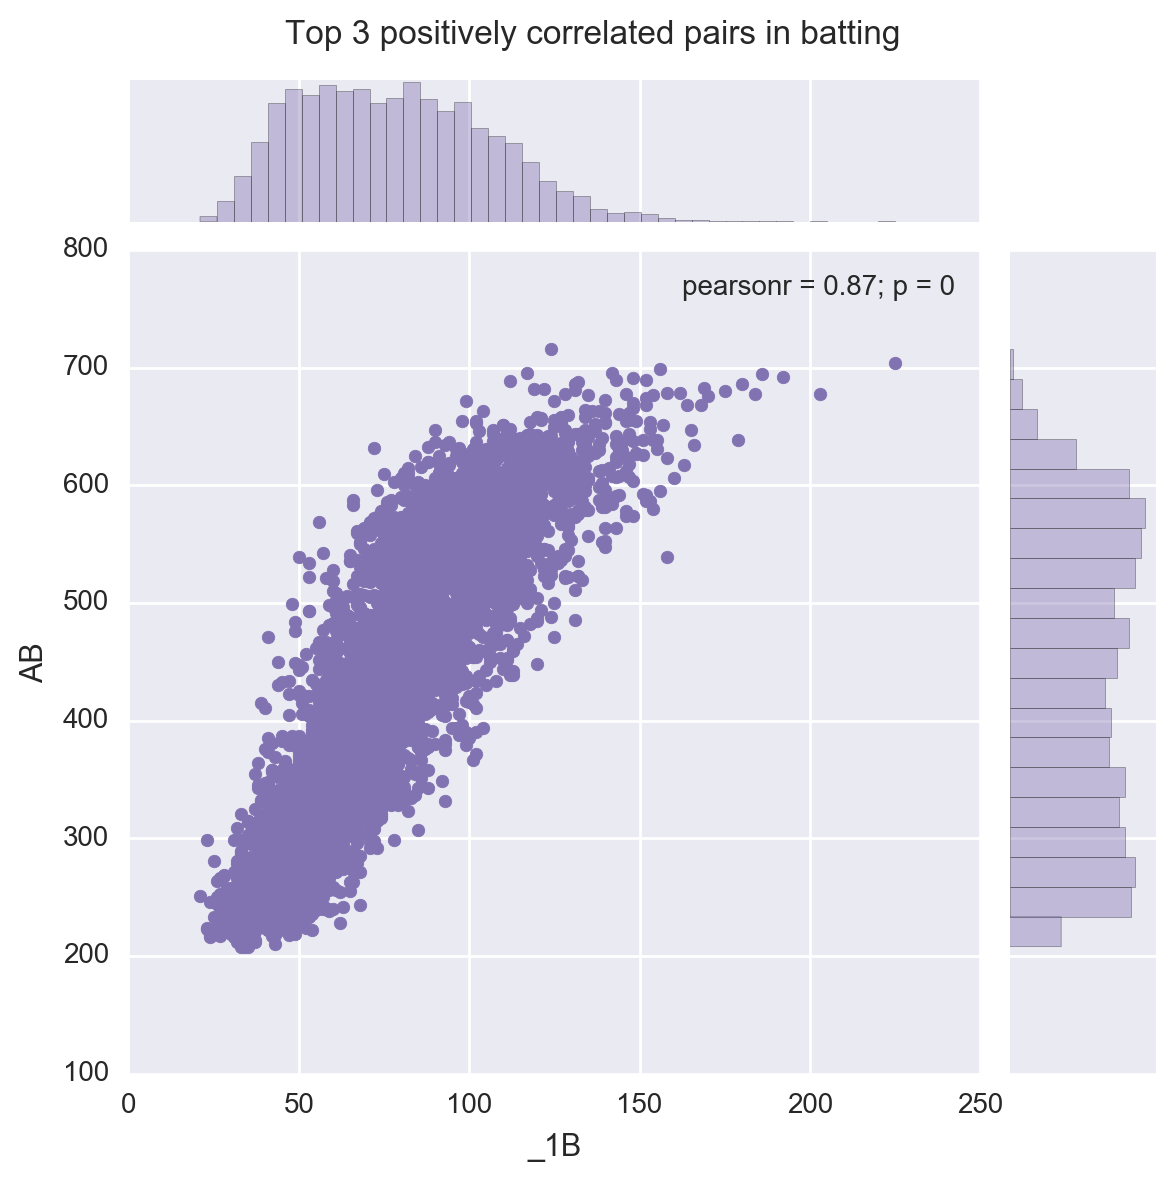

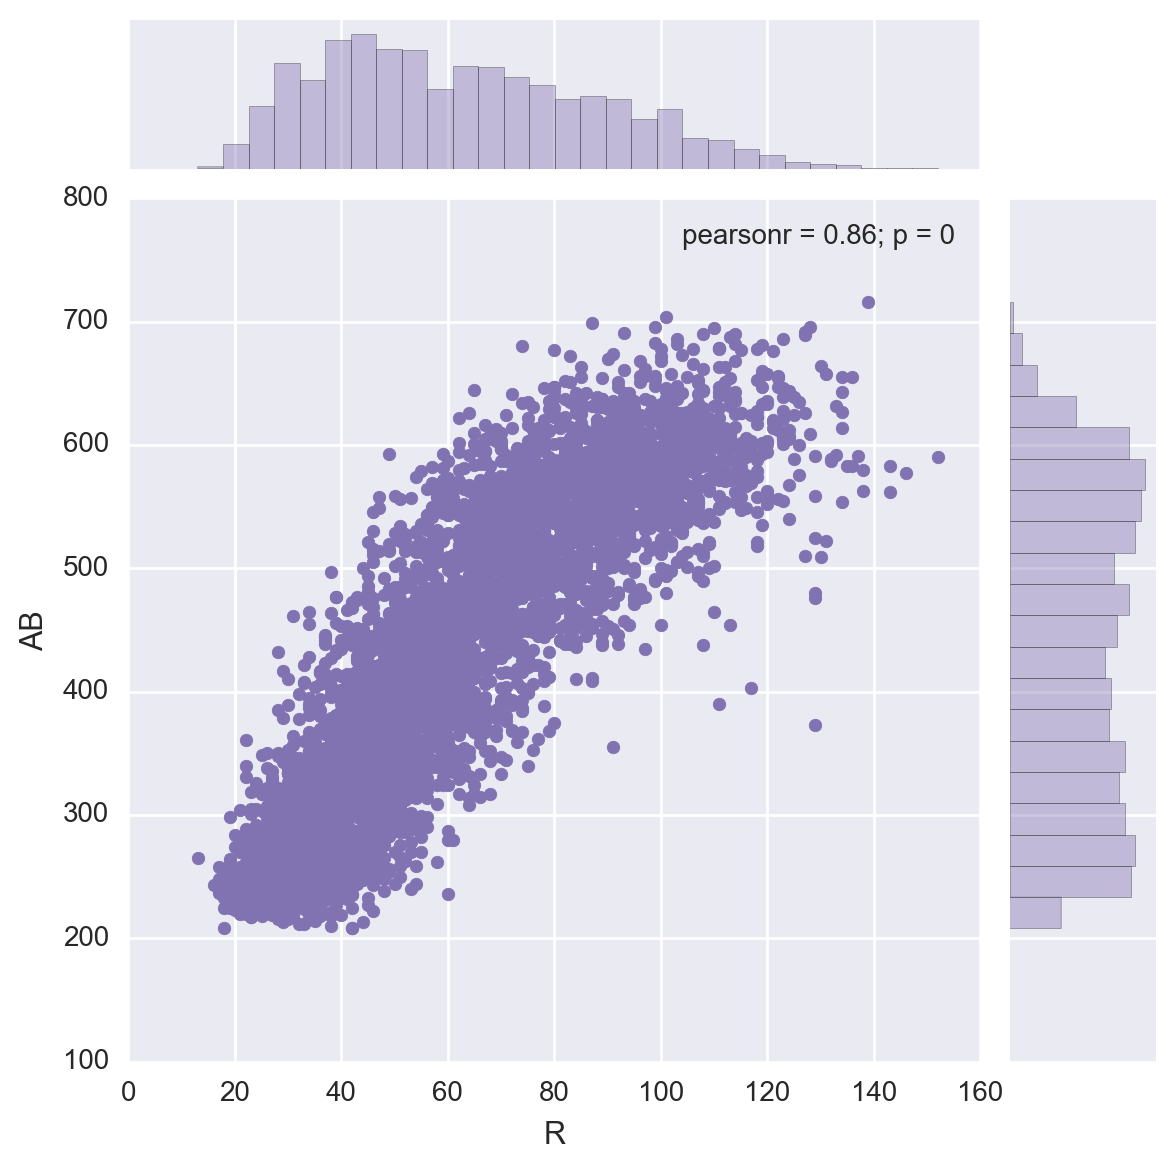

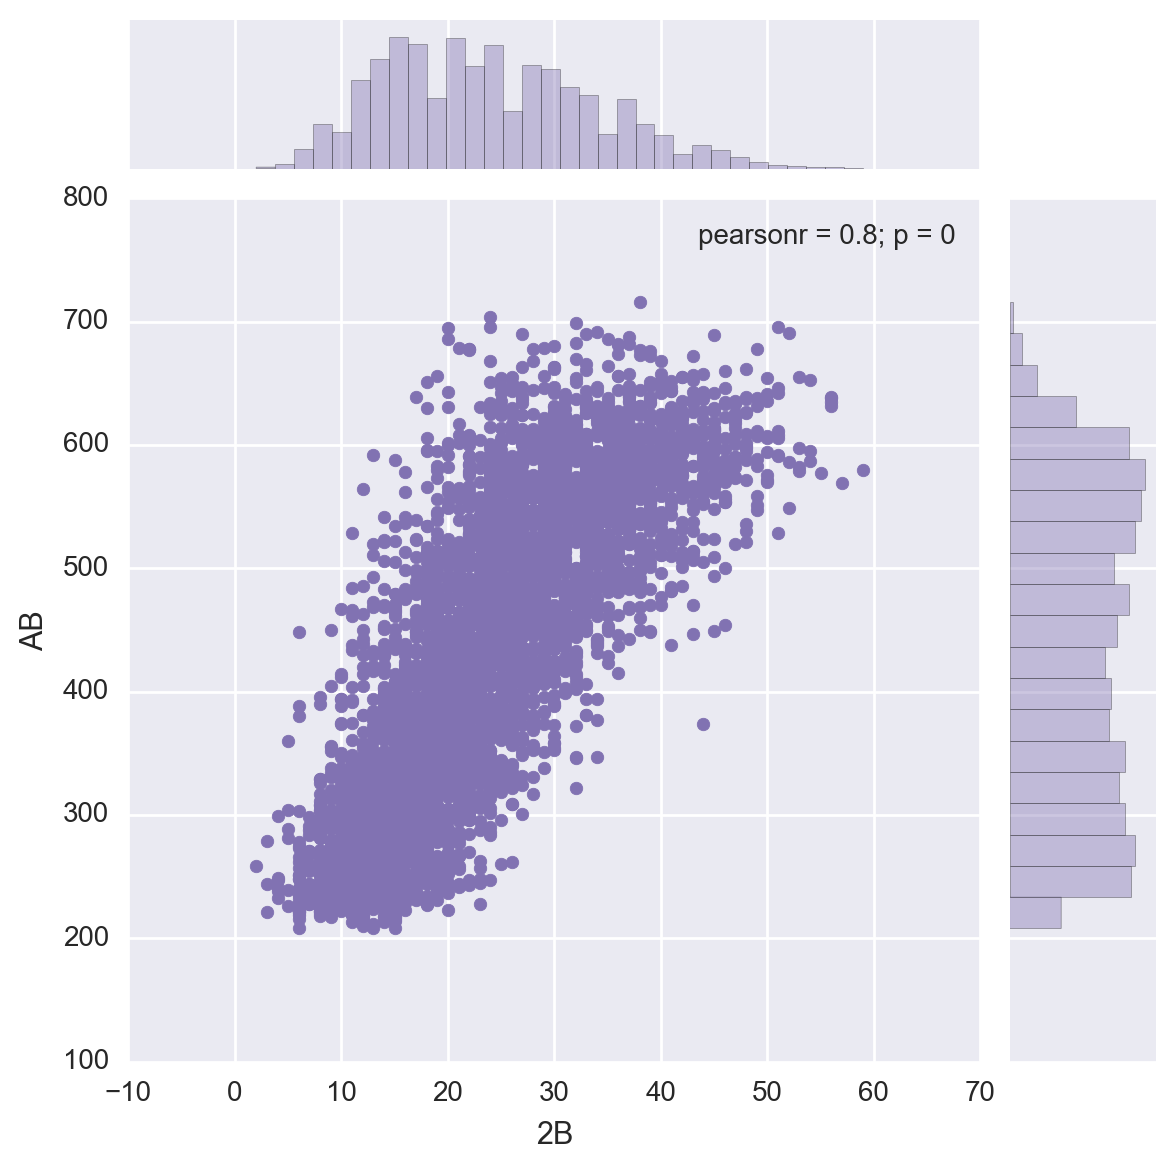

In [69]:
#plot top 3 positively correlated pairs in batting using a scatter plot with histograms of each corresponding dataset
AB__1B = sns.jointplot('_1B', 'AB', data = batting_98_12_251PA, color = 'm')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('Top 3 positively correlated pairs in batting')
R_AB = sns.jointplot('R', 'AB', data = batting_98_12_251PA, color = 'm')
AB_2B = sns.jointplot('2B', 'AB', data = batting_98_12_251PA, color = 'm')

The top three positively correlated stats in batting are 1B(singles)/AB(At Bats), R(Run)/AB(At Bats) and 2B(doubles)/AB(At bats). The scatter plots demonstrate that the relationships are indeed linear and the trend is clear. AB measures the number of times the batter gets the chance to bat and it seems to be highly correlated with the other three stats that tracks getting on base(1B and 2B) and scoring for the team(R). 

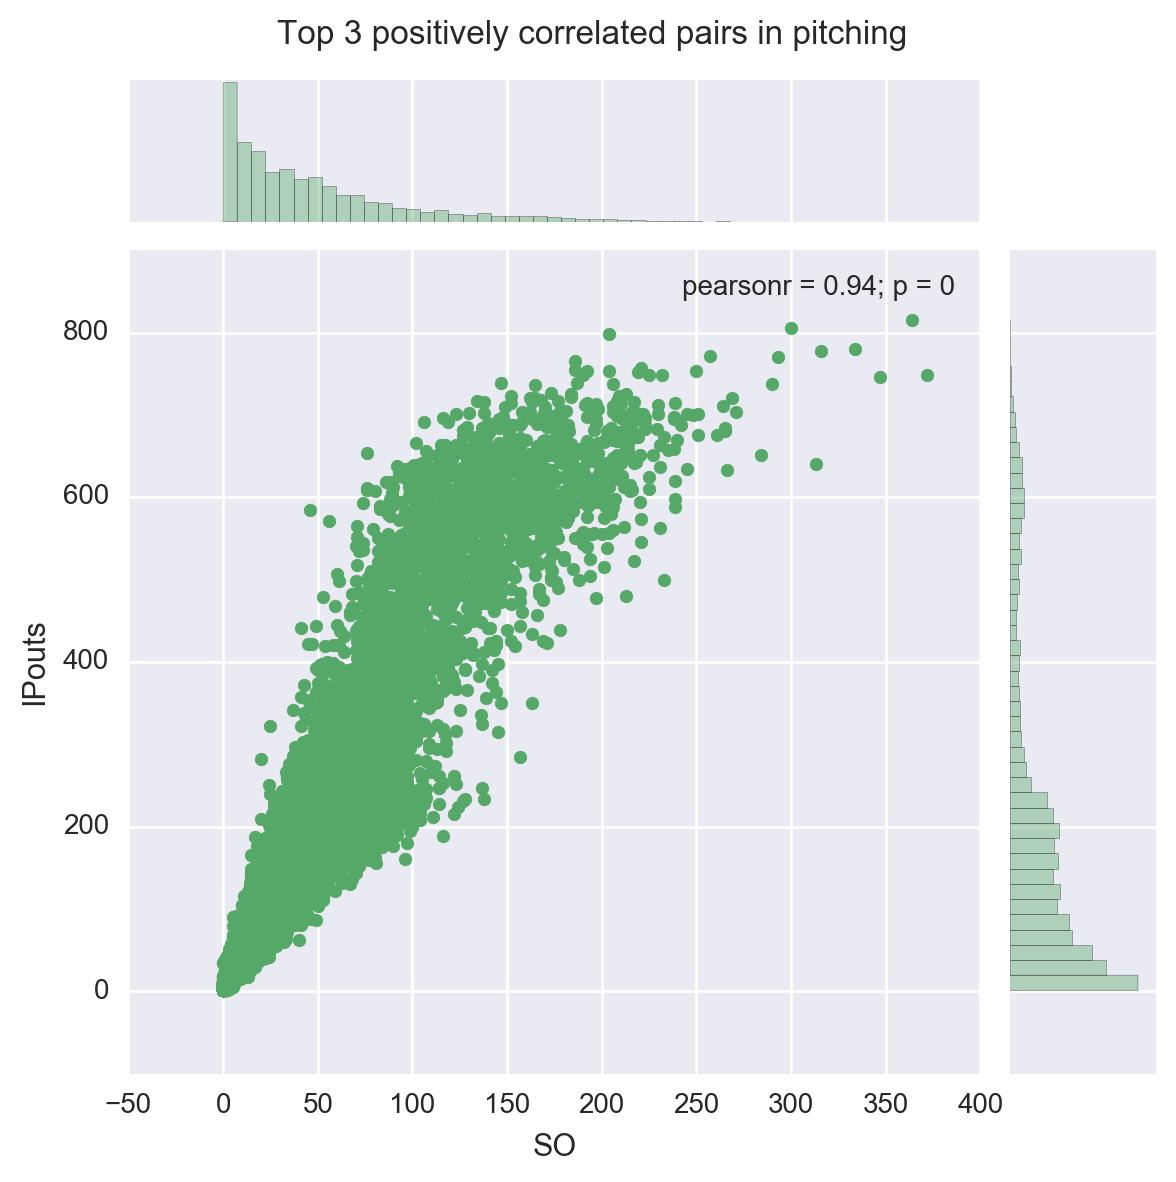

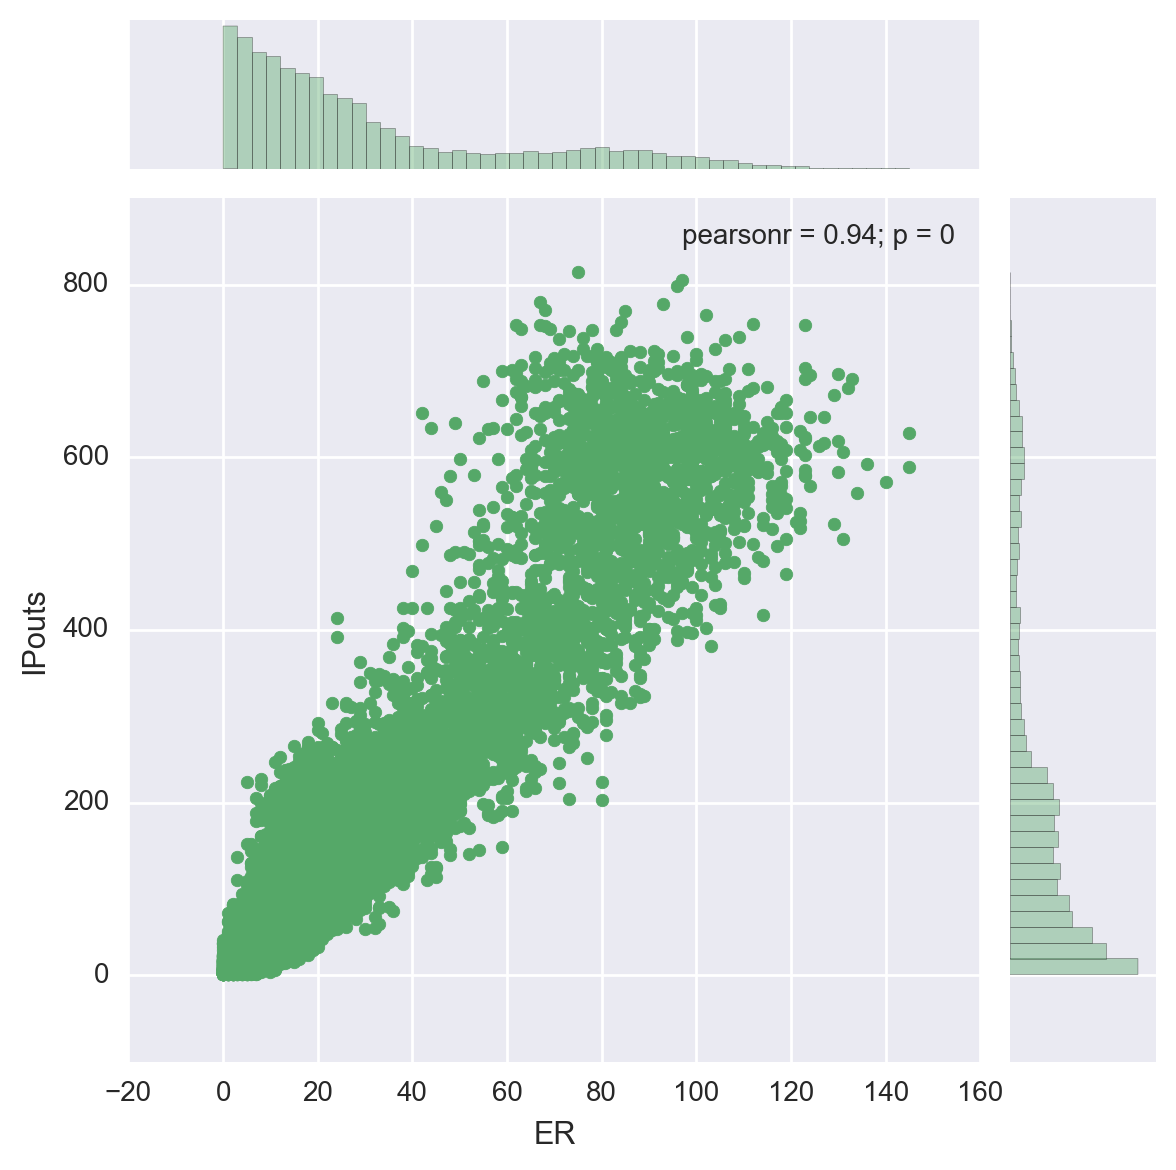

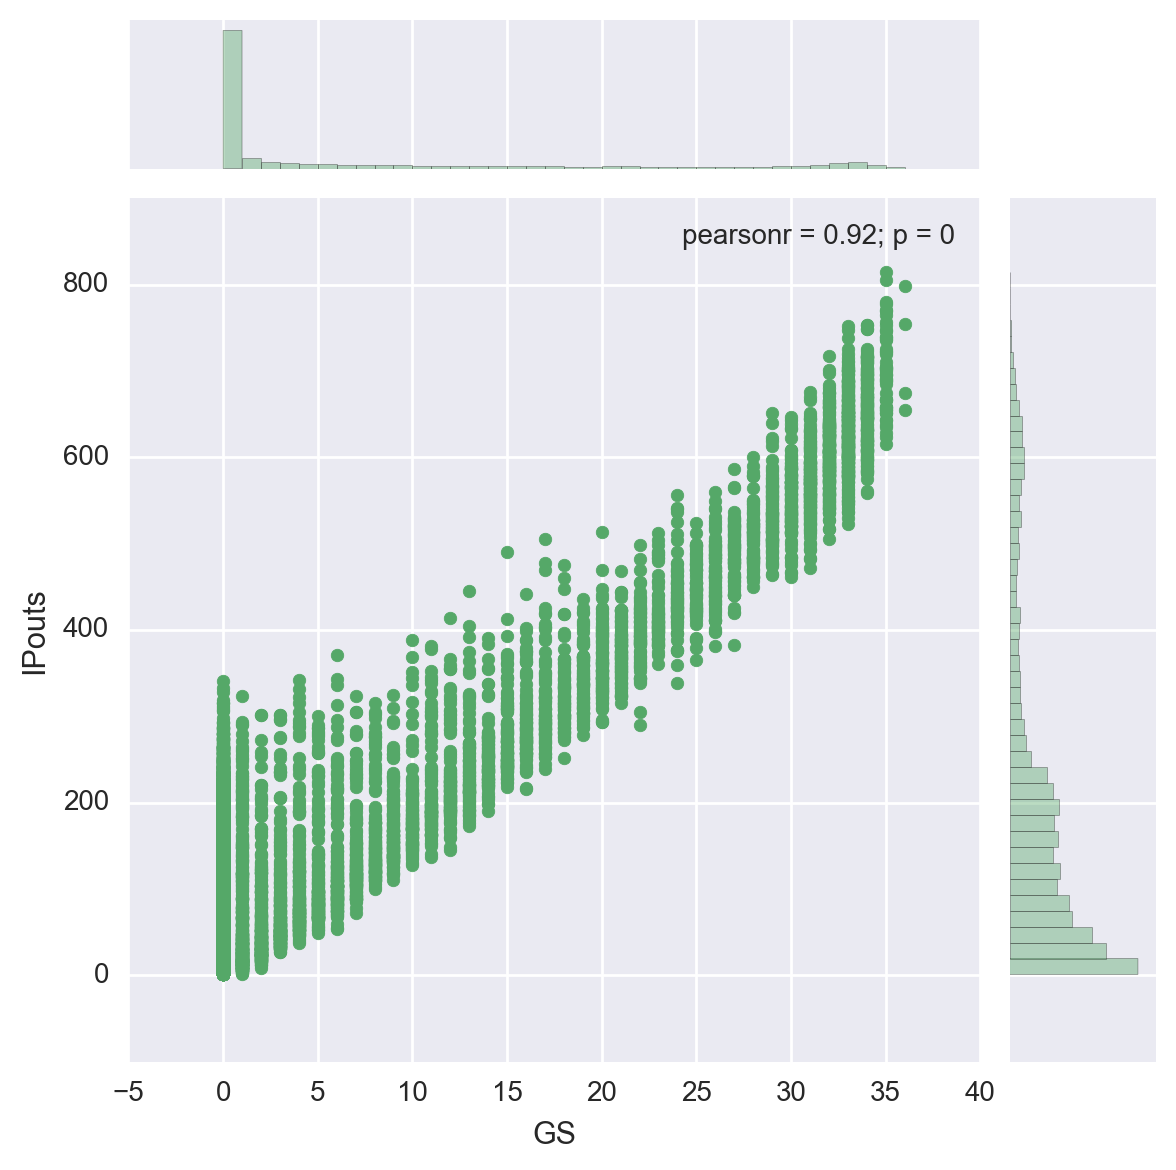

In [70]:
#plot top 3 positively correlated pairs in pitching
SO_IPouts = sns.jointplot('SO', 'IPouts', data = pitching_98_to_12_no0IPouts, color = 'g')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('Top 3 positively correlated pairs in pitching')
ER_IPouts = sns.jointplot('ER', 'IPouts', data = pitching_98_to_12_no0IPouts, color = 'g')
GS_IPouts = sns.jointplot('GS', 'IPouts', data = pitching_98_to_12_no0IPouts, color = 'g')

The top three positively correlated pitching stats are SO(Strike Outs)/IPouts(Outs Pitched), ER(Earned Runs)/IPouts(Outs Pitched) and GS(Games Started)/IPouts(Outs Pitched). Again, the scatter plots showed that the trend is linear. In pitching, PIouts is the metric that measures how often a pitcher played in the game and in this case, it positively correlated with three other stats, SO and ER, which are metrics to a pitcher's ability to stop the opponents from scoring and GS which is a metric tracking the starting pitcher's participation in the game.

In [71]:
# find lowest pearson r value for each column with it's corresponding variable and the pvalue

def get_smallest(column):
    '''This function takes a pandas dataframe column and returns the smallest value in that column with the 
    corresponding row label'''
    sorted_column = column.sort_values(ascending = False)
    return pd.Series([sorted_column[-1], sorted_column.index[-1]])

# batting
batting_lowest_pearsonr = batting_98_12_251PA_pearsonr.apply(get_smallest).transpose().rename(columns = {0:'pearsonr',
                            1: 'variable_Y'})
batting_lowest_pearsonr.sort_values('pearsonr', inplace = True)

# pitching
pitching_lowest_pearsonr = pitching_98_to_12_no0IPouts_pearsonr.apply(get_smallest).transpose().rename(columns = 
                            {0:'pearsonr', 1: 'variable_Y'})
pitching_lowest_pearsonr.sort_values('pearsonr', inplace = True)

# match p value to the lowest pearsons r table
batting_lowest_pearsonr = batting_lowest_pearsonr.assign(p_value = match_pvalue(batting_lowest_pearsonr,
                                                                        batting_98_12_251PA_pearsonr_pvalue).values)
pitching_lowest_pearsonr = pitching_lowest_pearsonr.assign(p_value = match_pvalue(pitching_lowest_pearsonr,
                                                                pitching_98_to_12_no0IPouts_pearsonr_pvalue).values)

# check if the p_value is less than 0.05 to reject the null hypothesis

batting_lowest_pearsonr = batting_lowest_pearsonr.assign(Null_Hypothesis_Rejected = 
                                                           (batting_lowest_pearsonr['p_value'] <= 0.05))
pitching_lowest_pearsonr = pitching_lowest_pearsonr.assign(Null_Hypothesis_Rejected = 
                                                            (pitching_lowest_pearsonr['p_value'] <= 0.05))

print "BATTING"
batting_lowest_pearsonr = batting_lowest_pearsonr[['variable_Y', 'pearsonr', 'p_value', 'Null_Hypothesis_Rejected']]
print batting_lowest_pearsonr
print "------------------------------------------------------------------------------------------------"
print "PITCHING"
pitching_lowest_pearsonr = pitching_lowest_pearsonr[['variable_Y', 'pearsonr', 'p_value', 'Null_Hypothesis_Rejected']]
print pitching_lowest_pearsonr

BATTING
     variable_Y   pearsonr        p_value Null_Hypothesis_Rejected
HR           SH  -0.416095  5.833647e-188                     True
SH           HR  -0.416095  5.833647e-188                     True
IBB          SH   -0.24844   2.831120e-64                     True
BB           SH  -0.194929   8.838959e-40                     True
SO           SH  -0.194008   2.051756e-39                     True
GIDP         SH  -0.155592   8.771175e-26                     True
2B           SH   -0.13978   4.494089e-21                     True
SF           SH  -0.118808   1.285137e-15                     True
SB         GIDP -0.0977443   5.004390e-11                     True
3B         GIDP -0.0814162   4.522513e-08                     True
CS          IBB -0.0552869   2.067987e-04                     True
R            SH -0.0503646   7.254787e-04                     True
HBP          SH -0.0258503   8.293556e-02                    False
AB           SH  0.0235447   1.142882e-01             

For the HBP(Hit By Pitcher)/ SH(Sacrifice Hit) and AB(At Bats)/ SH(Sacrifice Hit) pairs, the *P*-values are greater than 0.05 so we fail to reject the Null Hypothesis. Therefore, the correlation for these two pairs are not statistically significant. On the other hand, all other correlation pairs are statistically significant. 

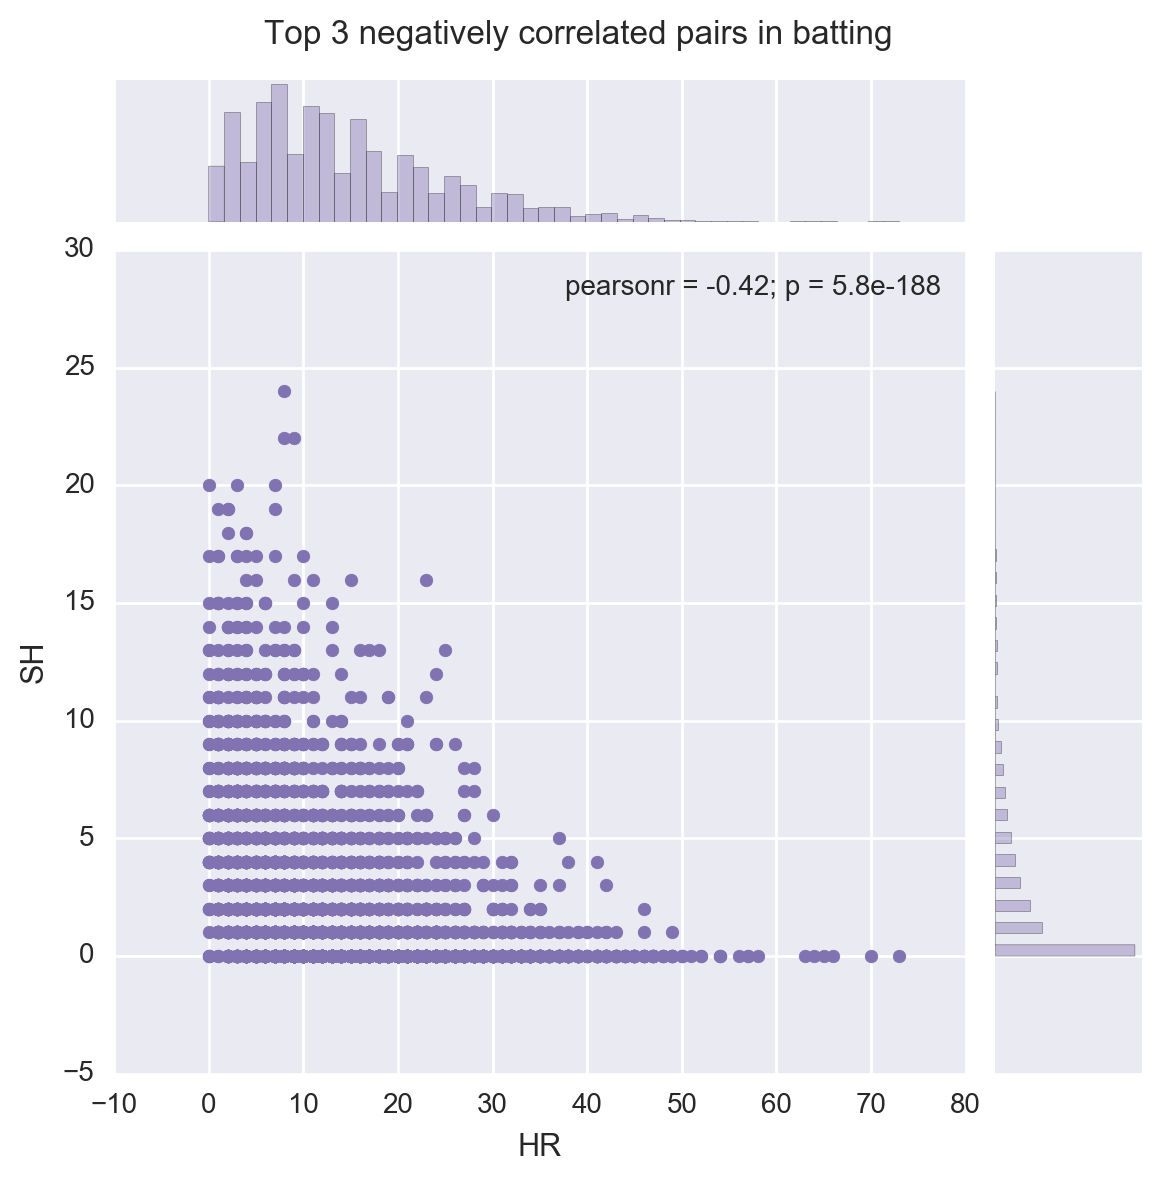

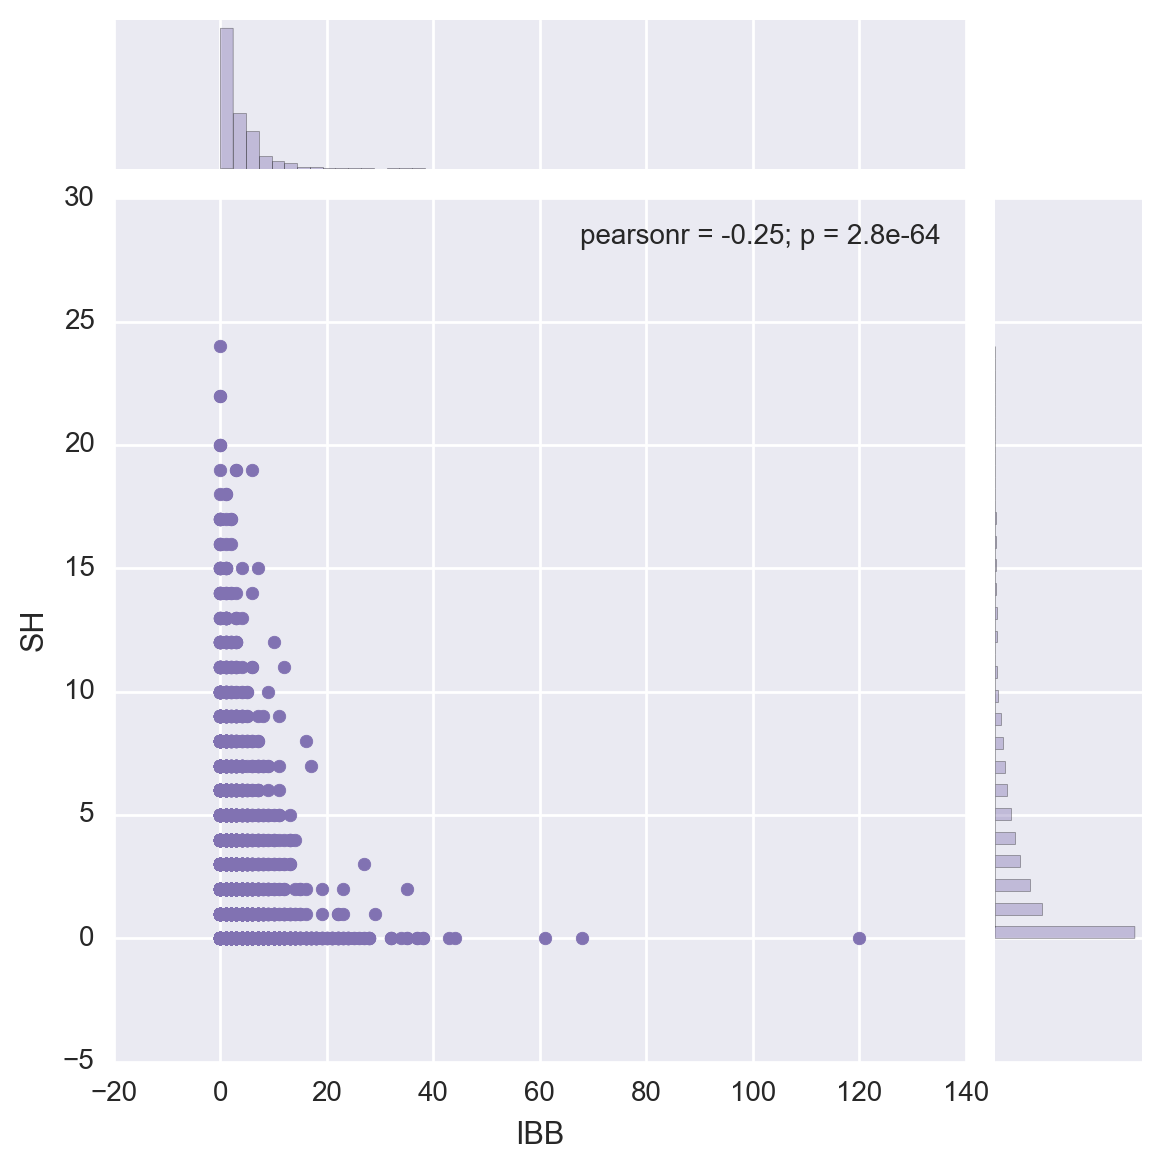

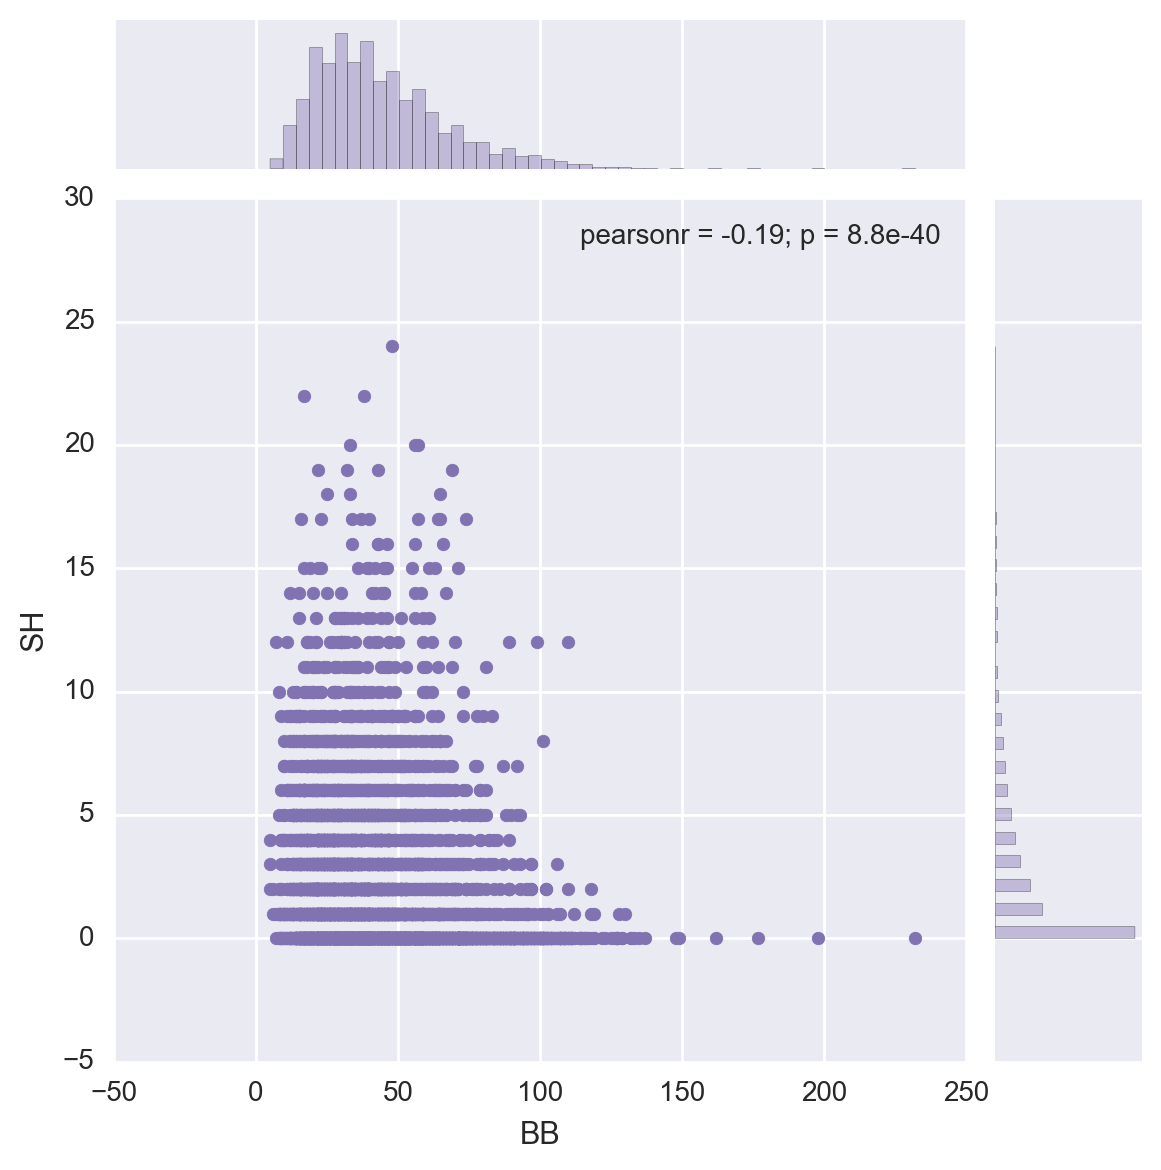

In [72]:
# plot top 3 negatively correlated pairs in batting

HR_SH = sns.jointplot('HR', 'SH', data = batting_98_12_251PA, color = 'm')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('Top 3 negatively correlated pairs in batting')
IBB_SH = sns.jointplot('IBB', 'SH', data = batting_98_12_251PA, color = 'm')
BB_SH = sns.jointplot('BB', 'SH', data = batting_98_12_251PA, color = 'm')

Unlike the clear trend in positively correlated pairs, the trend is less obvious in the negatively correlated pairs as shown by the lower absolute value of the pearson's *r*. SH(Sacrifice Hit), a stat that measures a tactic employed to advance runners on base for the team, is the stat that negatively correlated with HR(Home Run), IBB(Intentional walks) and BB(Base on Balls) which track the batter's ability to score or get on base. 

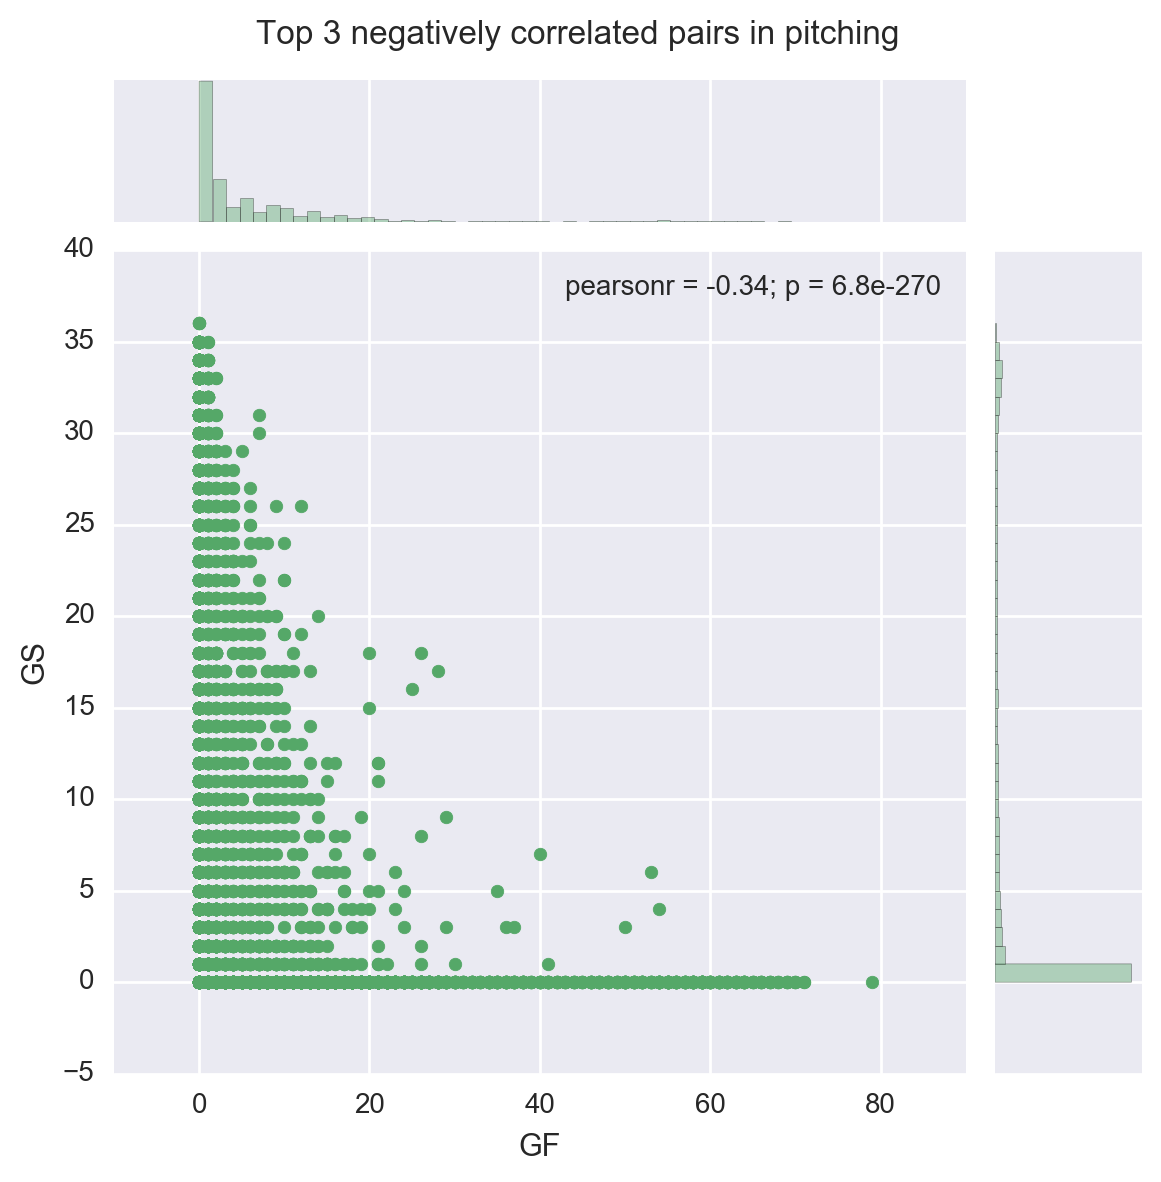

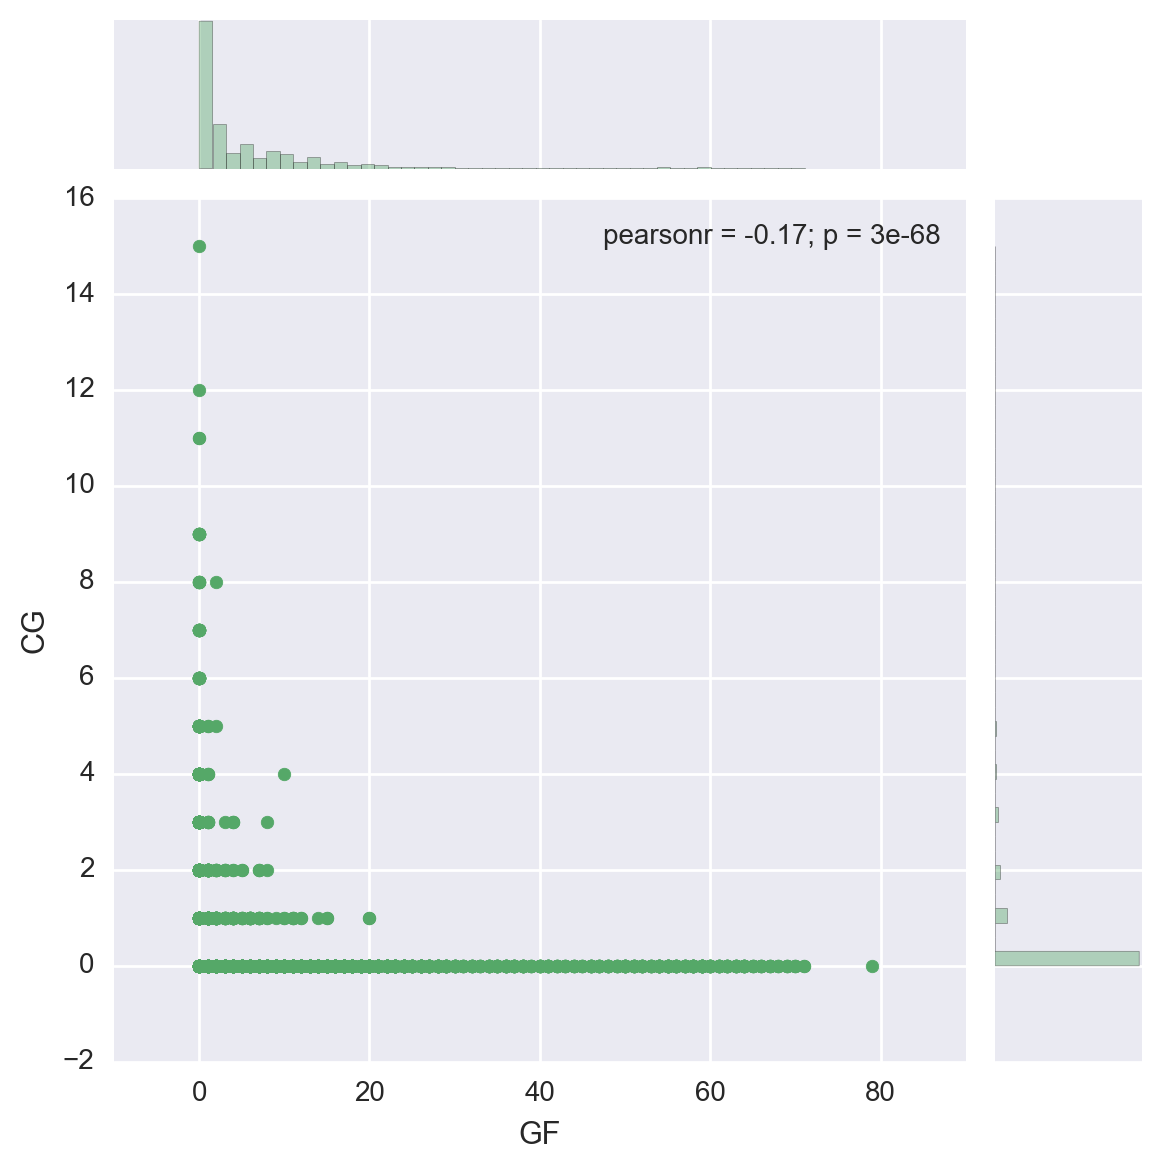

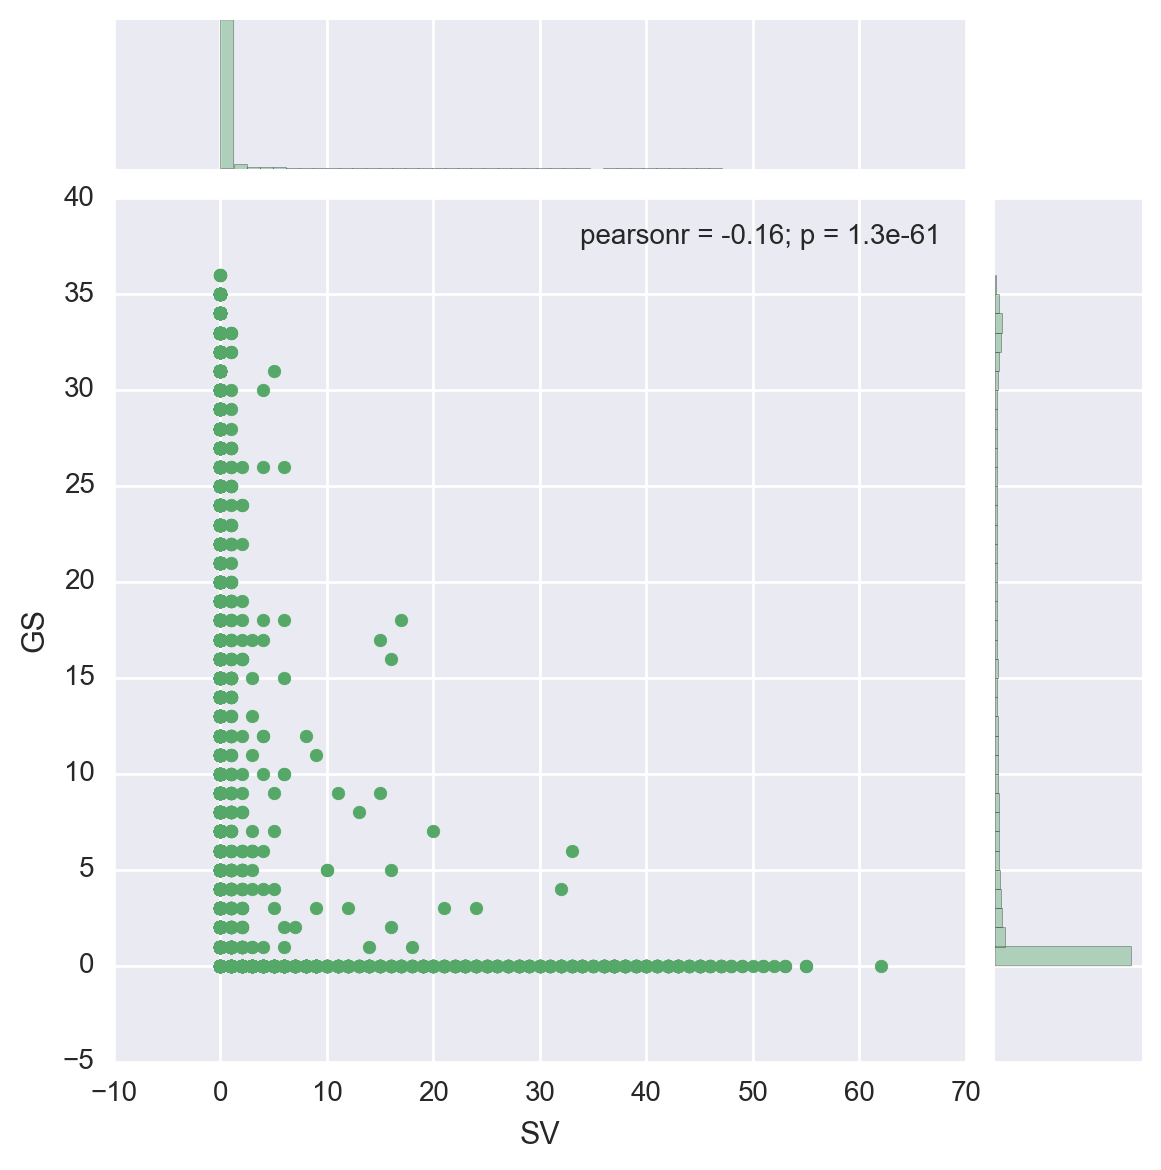

In [73]:
# plot top 3 negatively correlated pairs in pitching
GF_GS = sns.jointplot('GF', 'GS', data = pitching_98_to_12_no0IPouts, color = 'g')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('Top 3 negatively correlated pairs in pitching')
GF_CG = sns.jointplot('GF', 'CG', data = pitching_98_to_12_no0IPouts, color = 'g')
SV_GS = sns.jointplot('SV', 'GS', data = pitching_98_to_12_no0IPouts, color = 'g')

The top three negatively correlated pairs are GS(Game Started)/GF(Game Finished), CG(Complete Games)/GF(Game Finished) and GS(Game Started)/SV(Saves). The trend is not clear as others. However, the pair match are meaningful in the sense that they all correspond to metrics measuring pitchers of different roles. 

## Summary
The correlation analysis has led to the following observations:

1. Consistent with the Peason's *r*, the visualization of the two datasets using scatter plot showed that the positively correlated datasets show a true linear relationship between these two datasets. A trend of negative correlation is less obvious in these datasets.
2. For batting stats, the top three pairs of positively correlated stats are AB(At Bats) vs. 1B(singles), AB(At Bats) vs. R(Runs) and AB(At Bats) vs. 2B(doubles). These correlations suggest that higher attendance (as indicated by the at bats number) is positively associated with better performance (as indicated by the number of singles, runs and doubles). However, it's worth noting that correlation does not mean causation, so we can't draw any conclusion on whether this is due to the fact that it is the better performers that are playing in more games or playing in more games results in better performance. Neverthless, the very small p value associated with each coefficient indicates that the possibility of these two stats correlating by chance is unlikely. 
3. Another pair of stats that are positively correlated is SB(Stolen Bases) vs. CS(Caught Stealing). This makes sense since these are the only two stats in batting that measures base stealing so for players that perform this action frequently, it's more likely that they would have high numbers on both.
4. In pitching stats, the top three pairs of positively correlated stats are IPouts(Outs Pitched) vs. SO(Strikeouts), IPouts(Outs Pitched) vs. ER(Earned Runs) and IPouts(Outs Pitched) vs. GS(Game Started). These correlations suggest that higher attendance (as indicated by the IPouts number) can be positively associated with either good performance (as indicated by SO), bad performance (as indicated by ER) or the starting position (as indicated by GS). 
5. Even though negative correlation is not obvious in these datasets, we can still observe meaningful negative association, specially within the pitching stats. In general, these are the stats that are performed by different type of pitchers so are less likely to show positive correlation. For example, GS(Game Started)-- starter vs. GF(Game Finished)-- closer, CG(Completed Game)-- starter vs. GF(Game Finished)-- closer, and GS(Game Started)-- starter vs. SV(Saves)-- closer.

## Future Direction
Here we have two datasets that contain 18 batting stats and 21 pitching stats, respectively, from 1998 to 2012 in MLB. In addition to investigate the relationship between the stats, we can also look into the following questions for future exploration:

1. How do the stats change over year? Are there stats that have more drastic changes than others?
2. Are the stats significantly different between the two leagues?
3. How are the stats different between the teams?
4. Who are the players with the best performance in each stat over year? How did they do with the other stats? It there a trend?
5. Lastly, by merging these datasets with other performance indicators, eg. salary, awards awarded, team winning records, we can use the stats to gain insight into what are the important metrics to predict performance outcome.  

# 4. Generation of stat_salary dataset for Q2

To investigate what are the characteristics of the players with highest salaries, I will first merge the salary information into the previously generated batting datasets. I will then take a look at the quality of the merged dataset and split it into two datasets that contains top 25% salaries and the rest.

In [74]:
# Open and check salary dataset
salaries = pd.read_csv('Salaries.csv')
print salaries.head()
print "-------------------------------------------------------------------------------------"
print salaries.describe()

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000
-------------------------------------------------------------------------------------
             yearID        salary
count  24758.000000  2.475800e+04
mean    1999.891752  1.932905e+06
std        8.324492  3.190334e+06
min     1985.000000  0.000000e+00
25%     1993.000000  2.600000e+05
50%     2000.000000  5.250000e+05
75%     2007.000000  2.199643e+06
max     2014.000000  3.300000e+07


Like all the other stats the salary distribution also looks positively skewed with a large standard deviation.

In [75]:
# Merge datasets with batting stats
salaries_batting = batting_98_12_251PA.merge(salaries, on = ['yearID', 'playerID', 'teamID', 'lgID'], how = 'left')
print salaries_batting.head()
print "-------------------------------------------------------------------------------------"
print salaries_batting.describe()

    playerID  yearID  stint teamID lgID    G     AB     R      H    2B   3B  \
0  abbotje01    1998      1    CHA   AL   89  244.0  33.0   68.0  14.0  1.0   
1  abreubo01    1998      1    PHI   NL  151  497.0  68.0  155.0  29.0  6.0   
2  alexama02    1998      1    CHN   NL  108  264.0  34.0   60.0  10.0  1.0   
3  alfoned01    1998      1    NYN   NL  144  557.0  94.0  155.0  28.0  2.0   
4  alicelu01    1998      1    TEX   AL  101  259.0  51.0   71.0  15.0  3.0   

     HR   RBI    SB    CS    BB     SO   IBB  HBP   SH   SF  GIDP     PA  \
0  12.0  41.0   3.0   3.0   9.0   28.0   1.0  0.0  2.0  5.0   2.0  260.0   
1  17.0  74.0  19.0  10.0  84.0  133.0  14.0  0.0  4.0  4.0   6.0  589.0   
2   5.0  25.0   4.0   1.0  18.0   66.0   1.0  1.0  5.0  1.0   6.0  289.0   
3  17.0  78.0   8.0   3.0  65.0   77.0   1.0  3.0  2.0  3.0  11.0  630.0   
4   6.0  33.0   4.0   3.0  37.0   40.0   0.0  5.0  4.0  3.0   1.0  308.0   

     _1B    BA   OBP   SLG   OPS     salary  
0   41.0  0.28  0.30  

Looks likes there are missing values in some players' salary so I will take a closer look:
1. There is a 1% to ~12% data missing in salary from year 1998 to 2012(total of 343)
2. These records with missing salaries are pretty complete with high game numbers, suggesting that these are players that are active during the season and not free agent players or subs that might not have a complete salary record. (This is also expected because the stat dataset is a pre-selected dataset)
3. Most of the time the missing salary appears to be random happenings to a player's yearly salary. 
4. There is a pretty even distribution of missing data between the two leagues (AL:171, NL:172).
5. There are a few ways to deal with the missing numbers. One way is to fill up NaNs with the median or the mean. But given the high skeweness of the distribution. I am not confident that these numbers are really representative of what is missing so I decide to just drop the missing numbers first and check if this will affect the distribution of the three major stats (BA, RBI, HR). It seems that the BA are almost identical and there is a slight data loss at the peak of the distribution for RBI and HR, suggesting that the stats are not drastically changed with the deletion of the NaNs. Therefore, I will use the dataset with no NaNs for subsequent analysis.

In [76]:
# Calculate number of missing data point in salary column
NaNs = salaries_batting['yearID'].count() - salaries_batting['salary'].count()
print 'There are ', NaNs, ' missing values in the salary column'

There are  343  missing values in the salary column


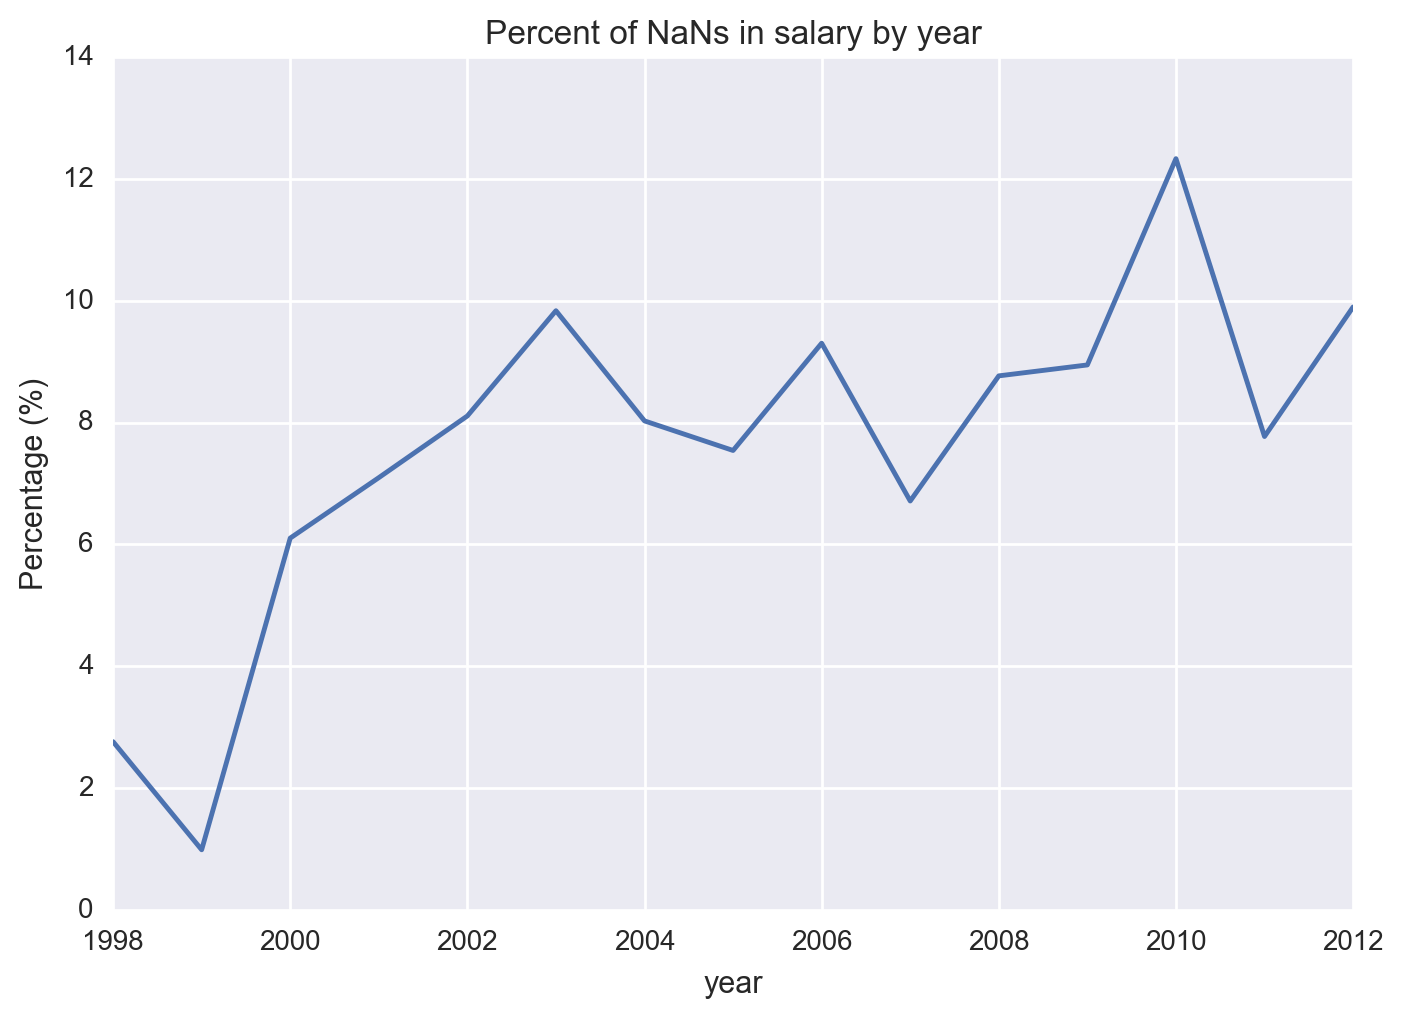

In [77]:
# Take a look at the NaNs in the salary column
ax = get_NaN_plot(salaries_batting, 'salary')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('year')
ax.set_title('Percent of NaNs in salary by year')

There is ~1% to 12% of data missing throughout the years in the salary column.

In [78]:
# Check if missing salaries are centered on specific players throughout these years or random missing information
# of some player at a random time

salaries_batting[salaries_batting['salary'].isnull() == True].groupby('playerID').count()

,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA,_1B,BA,OBP,SLG,OPS,salary
playerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abernbr01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
ackledu01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
alfonel01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
alomaro01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
alvarpe01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
amarial01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
anderma02,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
ariasjo01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
ausmubr01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0


Looks like the missing data points are sporadic for most of the players. 

In [79]:
# Check some specific examples
salaries_batting[salaries_batting['playerID'] == 'custja01']

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA,_1B,BA,OBP,SLG,OPS,salary
2741,custja01,2007,1,OAK,AL,124,395.0,61.0,101.0,18.0,1.0,26.0,82.0,0.0,2.0,105.0,164.0,2.0,1.0,0.0,6.0,6.0,507.0,56.0,0.26,0.41,0.50,0.91,NaN
3053,custja01,2008,1,OAK,AL,148,481.0,77.0,111.0,19.0,0.0,33.0,77.0,0.0,0.0,111.0,197.0,3.0,2.0,0.0,4.0,7.0,598.0,59.0,0.23,0.37,0.48,0.85,410000.0
3354,custja01,2009,1,OAK,AL,149,513.0,88.0,123.0,16.0,0.0,25.0,70.0,4.0,1.0,93.0,185.0,5.0,2.0,0.0,4.0,7.0,612.0,82.0,0.24,0.36,0.42,0.78,2800000.0
3664,custja01,2010,1,OAK,AL,112,349.0,50.0,95.0,19.0,0.0,13.0,52.0,2.0,2.0,68.0,127.0,0.0,5.0,0.0,3.0,6.0,425.0,63.0,0.27,0.40,0.44,0.84,NaN
3966,custja01,2011,1,SEA,AL,67,225.0,19.0,48.0,15.0,1.0,3.0,23.0,0.0,0.0,44.0,87.0,2.0,1.0,0.0,0.0,3.0,270.0,29.0,0.21,0.34,0.33,0.67,2500000.0


In this example, we see that the missing salary information are of year 2007 and 2010, again, quite random.

In [80]:
# check if there is a bias on the distribution of NaNs. 
# use lgID as an example

salaries_batting[salaries_batting['salary'].isnull()].groupby('lgID').count()

,playerID,yearID,stint,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA,_1B,BA,OBP,SLG,OPS,salary
lgID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,0
NL,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,0


The missing values are evenly distributed between the two leagues

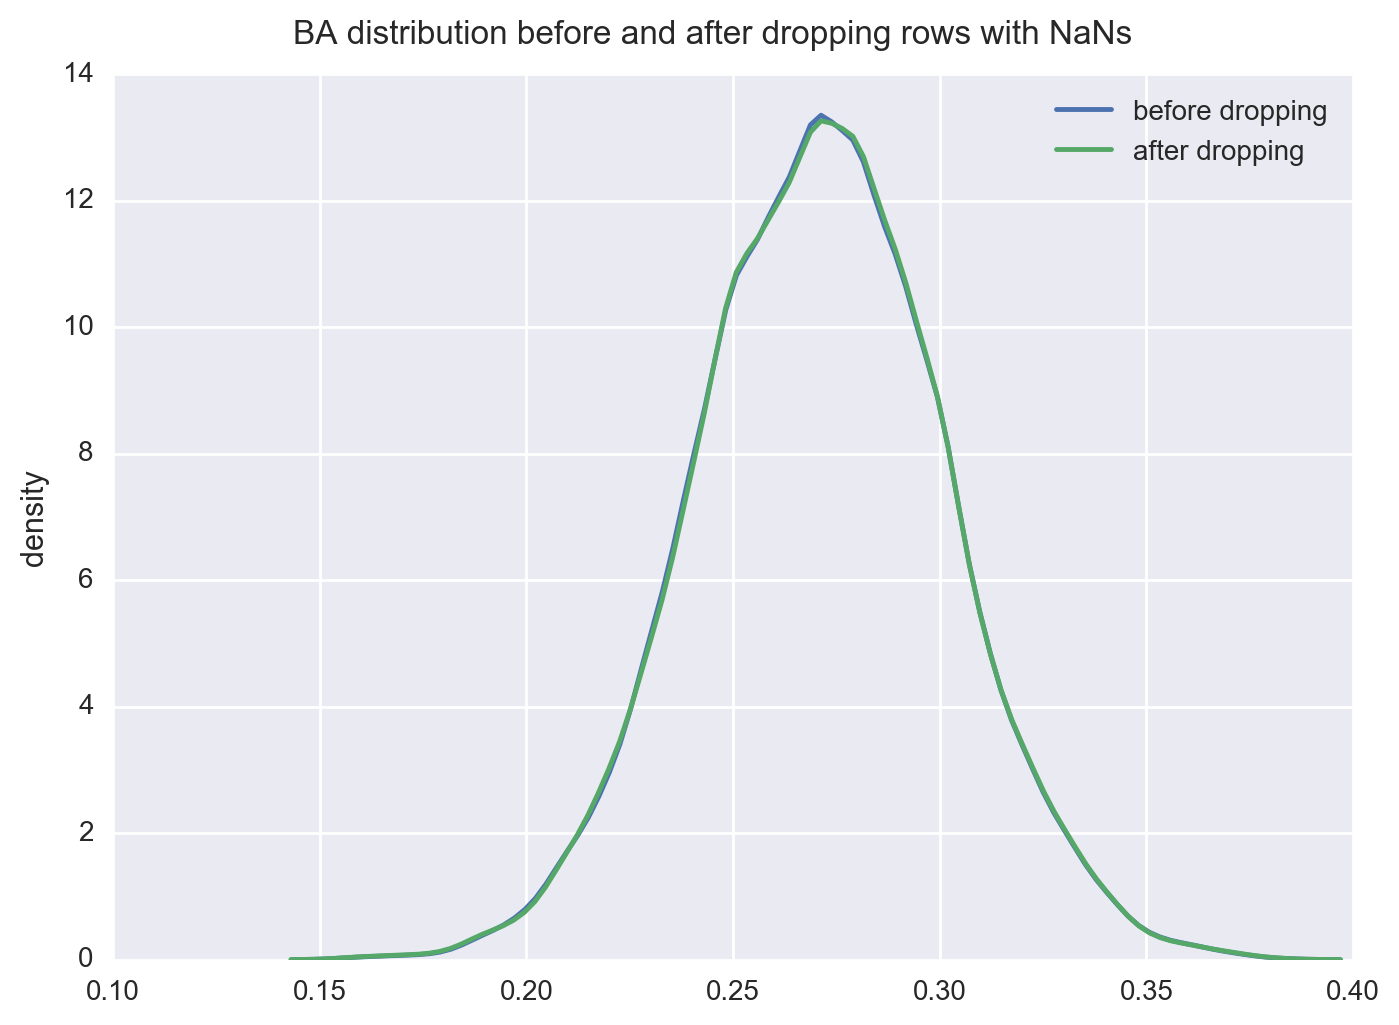

In [81]:
#dropna on rows that contain NaN in the salary column
salaries_batting_noNaNs = salaries_batting.dropna(axis = 0)

# compare stats from two datasets: check whether dropping the NaNs in salary affect the batting stats. 
# use BA as an example
ax = sns.kdeplot(salaries_batting['BA'], label = 'before dropping')
ax = sns.kdeplot(salaries_batting_noNaNs['BA'], label = 'after dropping')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('BA distribution before and after dropping rows with NaNs')
ax.set_ylabel('density')

There is almost no difference in BA(Batting Average) distribution before and after dropping the NaNs in the salary column.

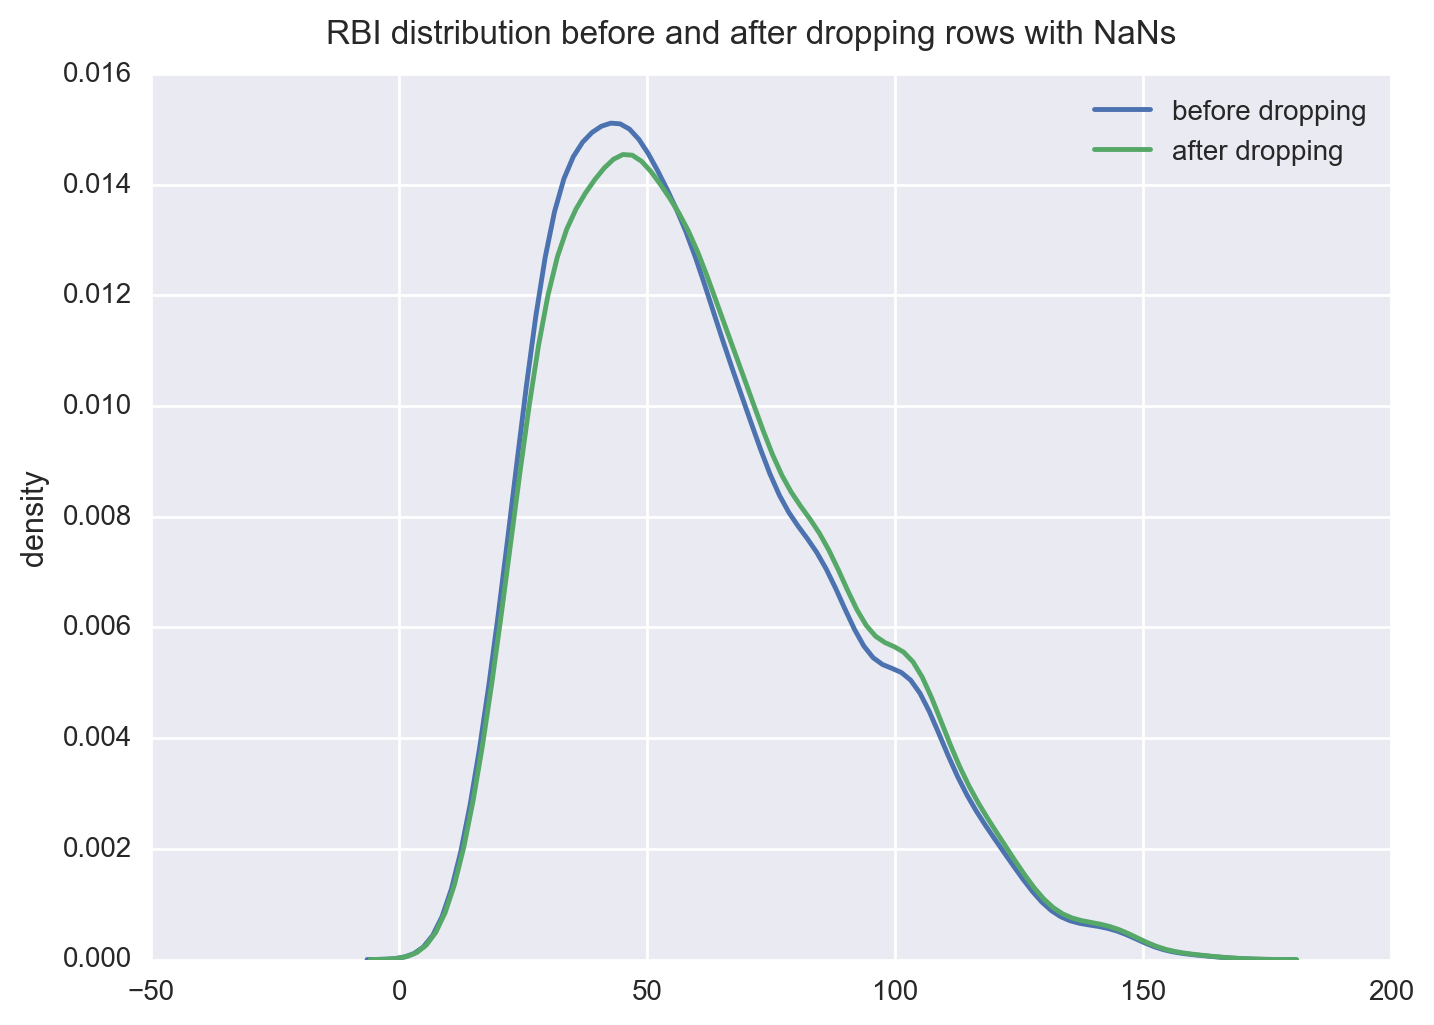

In [82]:
# compare stats from two datasets: check whether dropping the NaNs in salary affect the batting stats. 
# use RBI as an example
ax = sns.kdeplot(batting_98_12_251PA['RBI'], label = 'before dropping')
ax = sns.kdeplot(salaries_batting_noNaNs['RBI'], label = 'after dropping')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('RBI distribution before and after dropping rows with NaNs')
ax.set_ylabel('density')

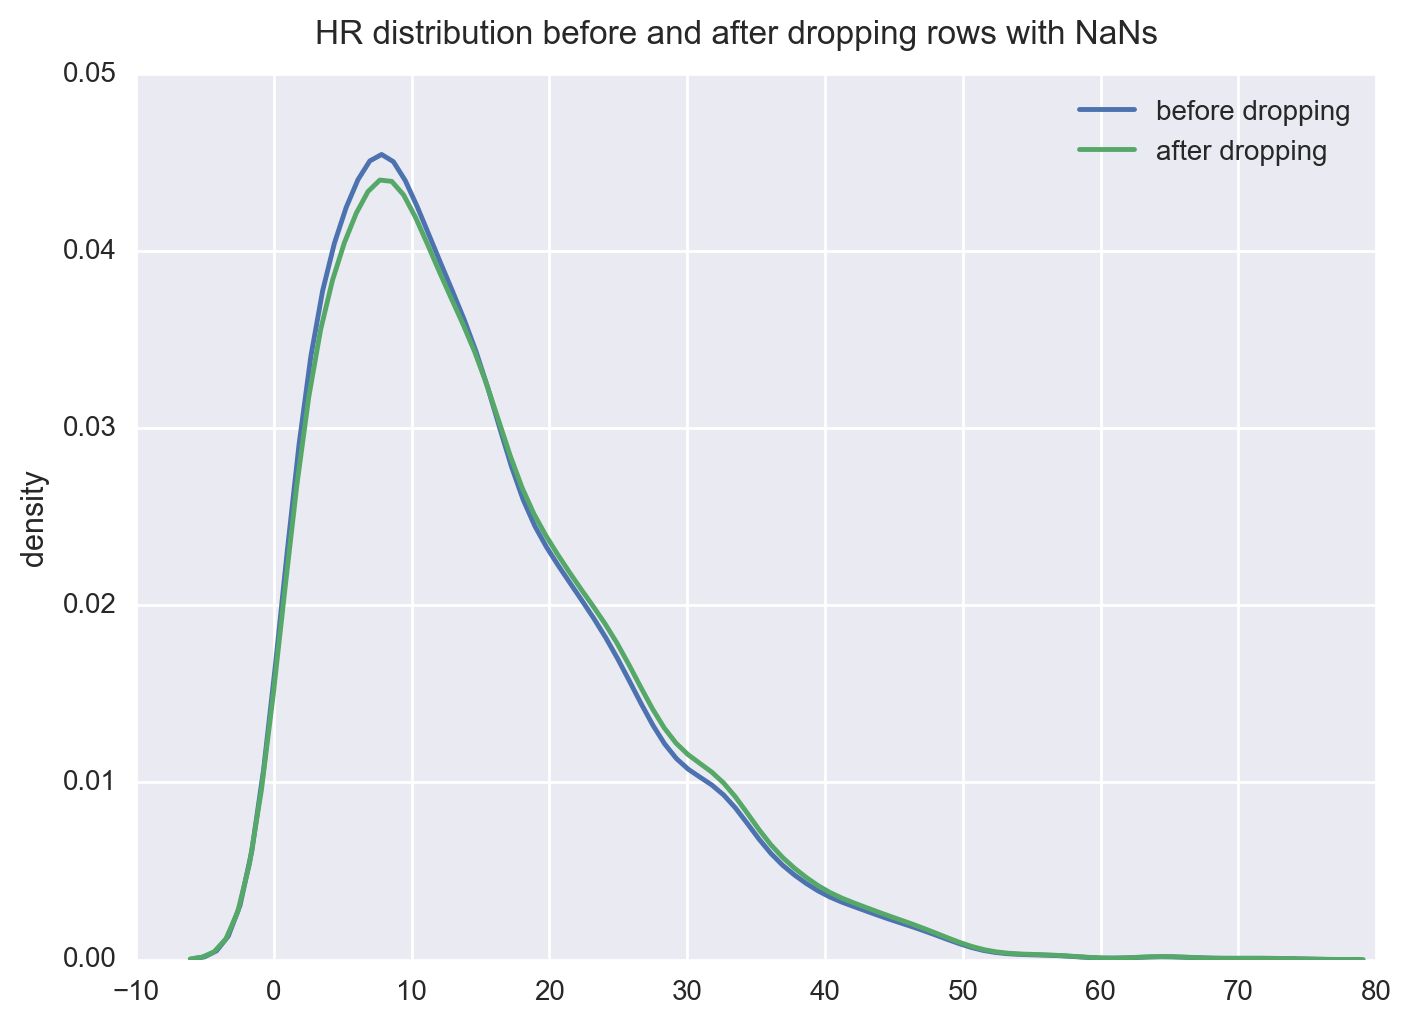

In [83]:
# compare stats from two datasets: check whether dropping the NaNs in salary affect the batting stats. 
# use HR as an example
ax = sns.kdeplot(batting_98_12_251PA['HR'], label = 'before dropping')
ax = sns.kdeplot(salaries_batting_noNaNs['HR'], label = 'after dropping')
plt.subplots_adjust(top=0.93)
sns.plt.suptitle('HR distribution before and after dropping rows with NaNs')
ax.set_ylabel('density')

There are only subtle differences in RBI(Run Batted In) and HR(Home Run) distribution before and after dropping the NaNs in the salary column.

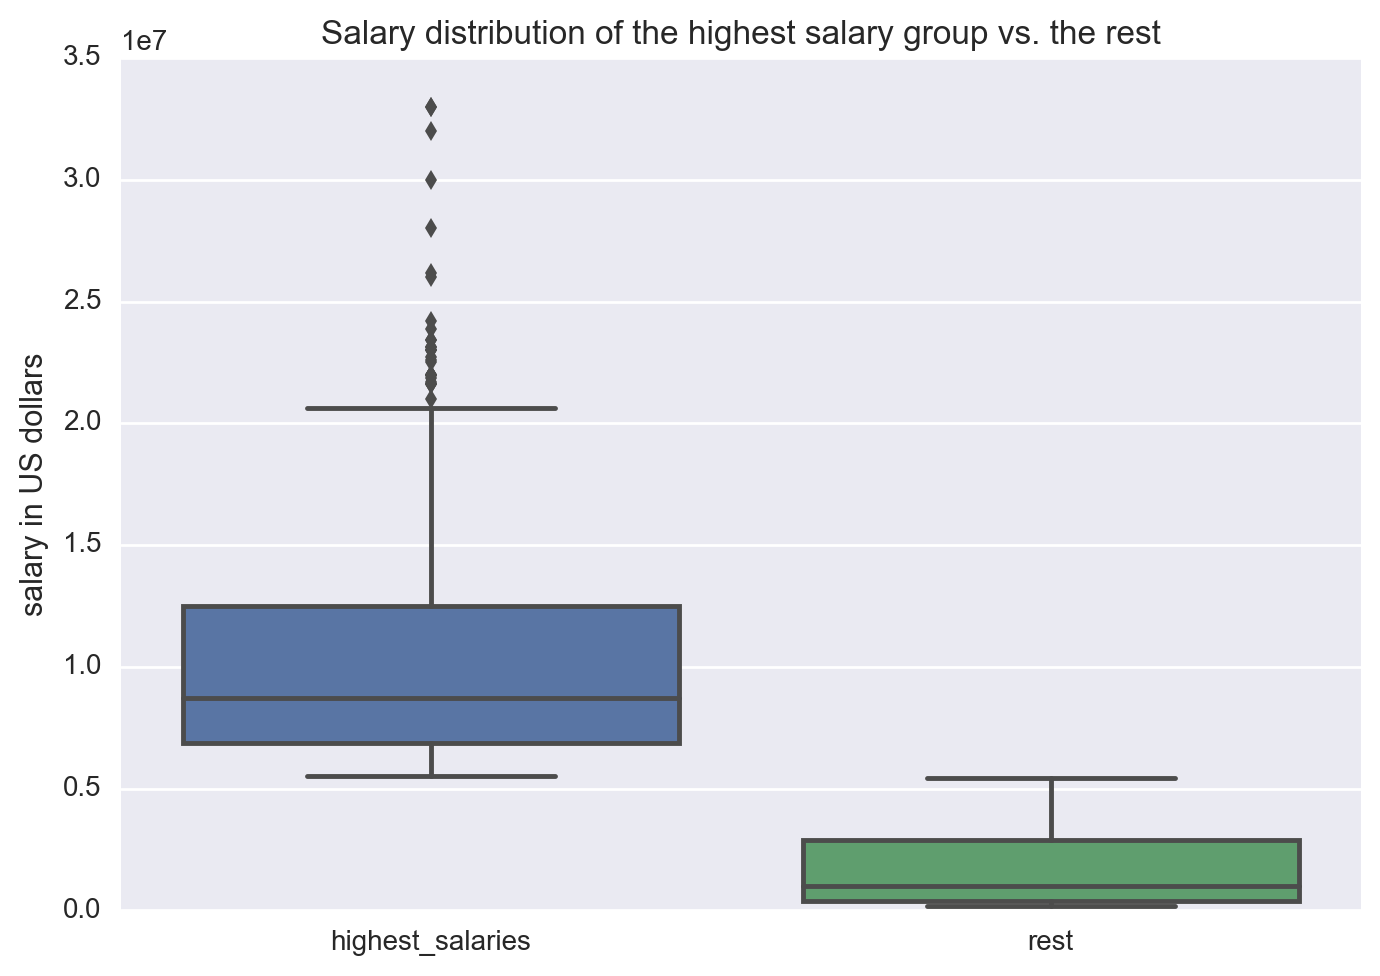

In [84]:
# split the dataset into top 25% (highest salaries) and the rest
# top 25%
highest_salaries_batting_noNaNs = salaries_batting_noNaNs[salaries_batting_noNaNs['salary'] >= 5.500000e+06]

# rest
rest_salaries_batting_noNaNs = salaries_batting_noNaNs[salaries_batting_noNaNs['salary'] < 5.500000e+06]

# use boxplot to compare the difference in salary distribution between the two groups

salary_data = pd.DataFrame([highest_salaries_batting_noNaNs['salary'], 
                            rest_salaries_batting_noNaNs['salary']]).transpose()
salary_data.columns = ['highest_salaries', 'rest']
ax = sns.boxplot(data = salary_data)
ax.set_title("Salary distribution of the highest salary group vs. the rest")
ax.set_ylabel('salary in US dollars')

This boxplot shows the salary distribution after separating the players into highest salary group vs the rest with the cut off line at ~500,000. We can see that for both groups the distribution is positively skewed. The highest salary has a larger salary range than the rest group. 

# 5. Q2: What are the characteristics of players with highest salaries

After splitting the stats records into two sub-datasets, I will compare the difference between each stats and investigate which ones show a significant difference, which will be a good indicator of the characteristics that separate players with higher salaries from the rest. 

I will use hypothesis testing to find out if the differences in baseball stats are significant using [Mann-Whitney *U* test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test). It does not required the assumption of normal distributions, but assumes that all samples from two groups are independent and the responses are ordinal, which will be fitting for many of the stats distribution in our datasets.

The null hypothesis $H_0$ can be formulated as $P(X>Y) = P(Y>X)$ (the probability of an observation from X exceeding an observation from second group Y equals to the probability of an observation from Y exceeding an observation from X). The alternative hypothesis $H_A$ is $P(X>Y) \neq P(Y>X)$. If we further assume that these two groups have the same distribution, the Mann-Whitney test can be used to [test for differences in medians and even means](https://graphpad.com/guides/prism/7/statistics/).

To perform the test, a *U* statistic is [calculated](http://users.sussex.ac.uk/~grahamh/RM1web/Wilcoxon%20Large%20N%202009.pdf):
1. Assign numerical ranks to all observations, with 1 being the smallest value. In case of a tie, assign the rank to the midpoint of unadjusted values.
2. Add up the ranks from all samples in group X.
3. $U_X = R_X - \frac{n_X(n_X + 1)}{2}$, where $R_X$ is the sum of the ranks in group X adn $n_X$ is the sample size of group X. the $U_Y$ can be calculated the same way and the smaller value of $U_X$ or $U_Y$ is the value used when consulting the significance table. 
4. When the sample size is large (N > 20), the distribution of *U* approximates normal distribution so the null hypothesis can be tested by a *z* test. The mean of the distribution of *U* value is $\mu = 0.5 * n_X * n_Y$. The standard deviation of the distribution with many tie values (which it is in this case) can be calculated as follows,
$$
\rho = \sqrt{\frac{n_Xn_Y(n^3 - n - T_c)}{12n(n-1)}}
$$
where $n$ is the total sample size, $T_c$ (the total sum of the ties) $= \sum(t^3 - t)$. $t$ is the number of ties at each tied value.
5. Calculate the *U critical value* for a given significance level: $U_{critical} = \mu - z*\rho - 0.5$. For a 0.05 significance level, *z* = 1.96 for a two-tailed test and 1.64 for a one_tailed test.
6. If $U$ is less or equal to $U_{critical}$, the null hypothesis is rejected and the difference is significant.

In [85]:
# write a function to take a value and calculate t**3 - t (t_value)
def compute_t_value(value):
    '''This function takes a value and 
    1) returns 0 if the value == 1
    2) else returns (value**3 - value)'''
    if value == 1:
        return 0
    else:
        t_value = (value**3) - value
        return t_value

# write a function to compute the total sum of the ties Tc
def compute_Tc(series):
    '''This function takes a pandas series or numpy 1D array and returns the total sum of the ties: Tc'''
    grouped_series = series.groupby(series).count()
    Tc = grouped_series.apply(compute_t_value).sum()
    return Tc

# write a function to compute U critical 
def perform_MannWhitneyU(x_series, y_series):
    '''This function takes two series and returns (U, pval, U_critical, outcome of hypothesis testing)
    U and pval are from scipy.stats.mannwhitneyu, U critical is calculated for presence of tie values 
    in a dataset with large sample size'''
    
    # calculate U and pval
    U, pval = scipy.stats.mannwhitneyu(x_series, y_series, alternative = 'two-sided')
    
    # create a full series for calculating Tc
    series = x_series.append(y_series, ignore_index = True)
    Tc = compute_Tc(series)
    
    # calculate mu and sd
    n_x = len(x_series)
    n_y = len(y_series)
    n = n_x + n_y
    mu = 0.5*n_x*n_y
    sd = (float((n_x * n_y)*(n**3 - n - Tc))/float((12 * n *(n-1))))**0.5
    
    # calculate U critical for alpha = 0.05 two tailed test
    z = 1.96
    U_critical = round(mu-(z*sd)-0.5, 2)
    
    # print the outcome of the hypothesis testing
    outcome = ''
    if U >= U_critical:
        outcome = 'null hypothesis rejected'
    else:
        outcome = 'null hypothesis retained'
    
    return(U, round(pval, 5), U_critical, outcome)

# create a list that contains only the batting stats column names
batting_all_columns = list(batting_98_12_251PA)
non_stats_columns = ['yearID', 'stint', 'playerID', 'teamID', 'lgID', 'salary']
batting_stats = [column for column in batting_all_columns if column not in non_stats_columns]

In [86]:
# perform hypothesis testing
for batting_stat in batting_stats:
    print batting_stat,'_high: ', highest_salaries_batting_noNaNs[batting_stat].median()
    print batting_stat, '_rest: ', rest_salaries_batting_noNaNs[batting_stat].median()
    print ' U,         pval, U_critical, hypothesis testing outcome'
    print perform_MannWhitneyU(highest_salaries_batting_noNaNs[batting_stat], 
                               rest_salaries_batting_noNaNs[batting_stat])

G _high:  141.0
G _rest:  129.0
 U,         pval, U_critical, hypothesis testing outcome
(1936229.0, 0.0, 1558204.73, 'null hypothesis rejected')
AB _high:  509.0
AB _rest:  427.0
 U,         pval, U_critical, hypothesis testing outcome
(2075051.5, 0.0, 1558198.71, 'null hypothesis rejected')
R _high:  76.0
R _rest:  56.0
 U,         pval, U_critical, hypothesis testing outcome
(2189333.0, 0.0, 1558203.01, 'null hypothesis rejected')
H _high:  141.0
H _rest:  114.0
 U,         pval, U_critical, hypothesis testing outcome
(2114305.5, 0.0, 1558200.29, 'null hypothesis rejected')
2B _high:  27.0
2B _rest:  22.0
 U,         pval, U_critical, hypothesis testing outcome
(2064141.0, 0.0, 1558229.07, 'null hypothesis rejected')
3B _high:  1.0
3B _rest:  2.0
 U,         pval, U_critical, hypothesis testing outcome
(1410479.5, 0.0, 1559203.24, 'null hypothesis retained')
HR _high:  20.0
HR _rest:  11.0
 U,         pval, U_critical, hypothesis testing outcome
(2295419.0, 0.0, 1558236.04, 'null hy

The Null Hypothesis was retained for CS(Caught Stealing) and SH(Sacrifice Hit), indicating that there is no significant difference in the medians between the high salary group vs the rest. For the rest of the batting stats, there was a significant difference in their medians with p value < 0.05 with the exception of SB (p value = 0.44).

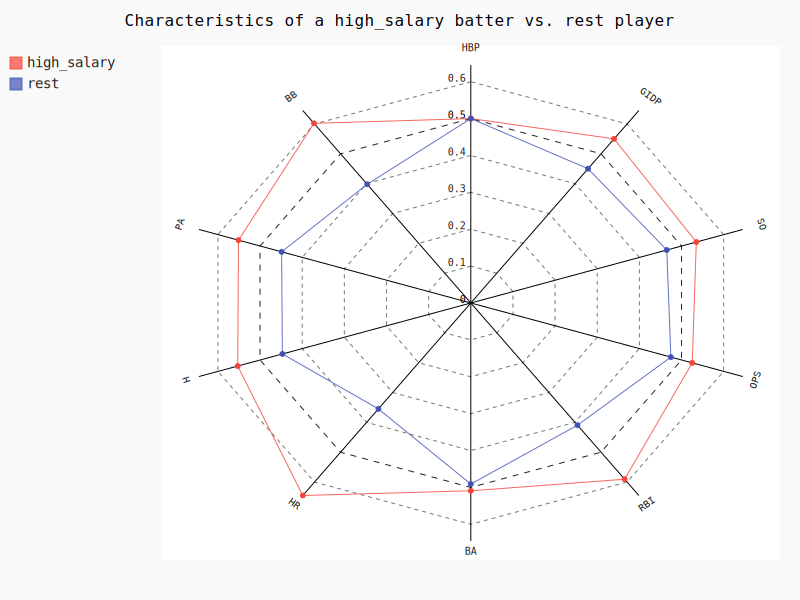

In [87]:
# use radar plot to compare characteristics of a high_salary player vs a rest player

# create a sublist that highlight differences between the two groups
batting_stats_sublist = ['HBP', 'BB', 'PA', 'H', 'HR', 'BA', 'RBI', 'OPS', 'SO', 'GIDP']
highest_salaries_median_sublist = [highest_salaries_batting_noNaNs[batting_stat].median() 
                                for batting_stat in batting_stats_sublist]
rest_salaries_median_sublist = [rest_salaries_batting_noNaNs[batting_stat].median()
                               for batting_stat in batting_stats_sublist]

# normalize all numbers to one so help the comparison stand out
normalized_highest_salaries_median_sublist = []
normalized_rest_salaries_median_sublist = []

for highest_salary_median, rest_median in zip(highest_salaries_median_sublist, rest_salaries_median_sublist):
    normalized_highest_salary_median = (highest_salary_median)/(highest_salary_median + rest_median)
    normalized_rest_median = (rest_median)/(highest_salary_median + rest_median)
    normalized_highest_salaries_median_sublist.append(normalized_highest_salary_median)
    normalized_rest_salaries_median_sublist.append(normalized_rest_median)

# draw a radar plot using pygal
radar = pygal.Radar()
radar.title = 'Characteristics of a high_salary batter vs. rest player'
radar.x_labels = batting_stats_sublist
radar.add('high_salary', normalized_highest_salaries_median_sublist)
radar.add('rest', normalized_rest_salaries_median_sublist)
radar.render_to_file('radar.svg')

# for some reason the plot wouldn't show directly so I have to save it first then display it
from IPython.display import SVG, display
display(SVG(filename = 'radar.svg'))

## Summary

1. HBP (Hit By Pitch) is the same for both high_salary and rest_salary datasets. This is consistent with the fact a batter hit by pitch should always be by chance thus no difference is observed between these two groups.
2. There are four stats, including 3B(Triples), SB(Stolen Bases), CS(Caught Stealing) and SH(Sacrifice Hits) of which players in rest_salary have higher numbers than players in high_salary. However, three of which, 3B, CS and SH, did not pass the hypothesis testing, suggesting that the difference is not statistically significant. SB has a *p*value of 0.44, suggesting that the possibility of the difference happening by chance is higher than 0.05. 
3. For the remaining 18 stats, players with higher pay have significantly bigger numbers than the rest of the players. These stats include those that measures attendance (G, AB, PA), batting ability(H, 1B, 2B, HR, BA, OBP, SLG, OPS), scoring ability(R, RBI), and others (BB, SO, IBB, SF, GIDP). HR showed the biggest difference between the two groups. Taken together, batters with higher salary play in more games, bat better, score more but also have more strikeouts and grounded into doubles.
4. It's worth noting that for the three stats (HR, BA, and RBI) that are used for competing for the triple crown in batting, BA did not show a drastic difference between the two groups. A more recently developed stats that aims at measuring the overall skills of a batter, OPS, has better ability in distinguishing players with higher salaries.

## Future Directions

1. What are the amounts of money each team/league spend on salary? Does it correlate with better team stats?
2. This dataset can also be used to train a linear regression model for prediction of player's salary based on the performance metrics they have.